# Finding interrelations of the UN SDG Targets and impute missing observations

### This project is divided into two major phases: 
1. It is intended to find cliques within the [UN SDG](https://sustainabledevelopment.un.org/?menu=1300) Targets.
2. Within one of the found cliques, missing observations of the time-series are inferred

Each Target has at least one quantitatively measurable Indicator associated whose measurements from 1984 to 2017 serve as our data points. The data set we are working with is for the entire world, i.e. the values presented are means over all countries. Regarding the first phase, for a more sophisticated analysis, but out of scope of this course, correlations in each country should be analysed separately.

<img src="Screenshot from 2018-04-19 10-08-40.png">

## 1. Find cliques

Import necessary packages and load our preprocessed data set

*if you want to see what happened in the preprocessing, see **prepare_df_for_analysis.ipynb** *

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pystan
import math
import os
import sklearn

In [2]:
# load csv
df = pd.read_csv("TargetsForAnalysis.csv")
df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.7,NaN,NaN,NaN,NaN
1,107,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.17,NaN
2,108,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.86,NaN
3,109,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.79,NaN
4,110,Population,Proportion of population covered by social pro...,1,1.3,1.3.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.08,NaN


See how many data points we have for each Indicator

In [3]:
intyears = list(range(1984, 2018))
#print(intyears)

years = []
for year in intyears:
    years.append(str(year))
    
#print(years)

In [4]:
def getnumberofyearswithdata(r):
    n = 0
    for year in years:
        if ~np.isnan(r[year]):
            n+=1
    return n

In [5]:
# new column with number of data points per Indicator
df['Years with values'] = df.apply(getnumberofyearswithdata, axis=1)

In [6]:
df.head()
df.shape

(197, 43)

We need at least two data points to conclude any kind of correlation

In [7]:
df_new = df.loc[df['Years with values'] > 1]

# see how many rows we deleted
print(df_new.shape)
df_new.head()

(120, 43)


,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
0,106,Population,Proportion of population below the internation...,1,1.1,1.1.1,Percent,Units,NaN,NaN,...,NaN,NaN,NaN,NaN,10.70,NaN,NaN,NaN,NaN,2
8,115,Population,Proportion of births attended by skilled healt...,3,3.1,3.1.2,Percent,Units,NaN,NaN,...,NaN,69.88,NaN,NaN,NaN,NaN,NaN,78.49,NaN,3
9,129,Population,Participation rate in organized learning (one ...,4,4.2,4.2.2,Percent,Units,NaN,NaN,...,59.41,60.44,62.64,64.64,65.20,66.59,NaN,NaN,NaN,12
10,130,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,54.02,55.55,55.91,55.77,55.22,55.03,54.81,NaN,NaN,16
11,131,Population,Proportion of population using safely managed ...,6,6.1,6.1.1,Percent,Units,NaN,NaN,...,69.90,70.82,71.14,71.22,71.09,71.14,71.16,NaN,NaN,16


See how many Targets are associated with the Indicators we found

In [8]:
# create a list of Targets
e = list(df_new['Target'])
type(e[2])

str

In [9]:
df_new['Target'] = df_new.apply(lambda x: str(x['Target']), axis=1)

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
df_new.shape

(120, 43)

See which Targets are in our data frame

In [11]:
targets = list(set(df_new['Target']))

We know that one Target can have potentially more than one Indicator, and that Indicators can be separetely measured for, e.g., genders, age groups, etc.
But since we want to find interrelations between the Targets, only the row per Target with maximum amount of data is considered.

In [12]:
# create empty dictionary
target_dfs = {}

In [13]:
for t in targets:
    target_dfs[t] = df_new[df_new['Target']==t]

In [14]:
# show an example of Target with more than on Indicator
target_dfs['12.2']

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.690000e+00,1.010000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
178,78,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
179,79,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,6.573055e+16,6.932903e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
183,83,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,9.750000e+00,1.006000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
184,84,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,1.330000e-03,1.330000e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
185,85,Environment (Tonnes),"Domestic material consumption, domestic materi...",12,12.2,12.2.2,Metric Tons,Units,NaN,NaN,...,6.807354e+16,7.099971e+16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11


In [15]:
# find row with maximum amount of data points for each target
max_dfrows = {}

for target in targets:
    if target_dfs[target].shape[0] > 1:
        max_dfrows[target] = target_dfs[target].loc[target_dfs[target]['Years with values'].idxmax()].to_frame().T
    else:
        max_dfrows[target]=target_dfs[target]

In [16]:
frames = list(max_dfrows[target] for target in targets)

In [17]:
merged_df = pd.concat(frames, axis=0)

In [18]:
units = list(set(merged_df['Unit']))

In [19]:
units.remove('Percent')
units

['Constant USD', 'USD', 'Metric Tons']

In [20]:
not_percent = merged_df[merged_df['Unit'].isin(units)]
not_percent

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
177,77,Environment (Tonnes),"Material footprint, material footprint per cap...",12,12.2,12.2.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
174,74,Environment (Tonnes),"Material footprint, material footprint per cap...",8,8.4,8.4.1,Metric Tons,Units,NaN,NaN,...,9.69,10.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
191,95,Environment (Tonnes),CO2 emission per unit of value added,9,9.4,9.4.1,Metric Tons,Units,NaN,NaN,...,2.87486e+10,3.04504e+10,3.13544e+10,3.15929e+10,3.21294e+10,3.2381e+10,NaN,NaN,NaN,15
141,36,E&P (USD),Dollar value of all resources made available t...,17,17.19,17.19.1,USD,Units,NaN,NaN,...,1.40685e+08,3.51996e+08,4.83067e+08,2.08601e+08,4.43106e+08,3.49844e+08,NaN,NaN,NaN,9
140,20,E&P (Percent),"Net official development assistance, total and...",17,17.2,17.2.1,Constant USD,Billions,NaN,NaN,...,0.000114281,0.00012063,0.000119673,0.000115308,0.000121838,0.000123946,0.000131555,0.000143329,NaN,17


In [21]:
merged_df.head()

,Unnamed: 0,Category,Indicator Description,Goal,Target,Indicator Ref,Unit,Unit multiplier,1984,1985,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Years with values
169,102,Environment (Tonnes),Progress towards sustainable forest management,15,15.2,15.2.1,Percent,Units,NaN,NaN,...,NaN,7.09,NaN,NaN,NaN,11.01,NaN,NaN,NaN,2
60,117,Population,"Tuberculosis incidence per 100,000 population",3,3.3,3.3.2,Percent,Units,NaN,NaN,...,15.9,15.5,15.3,15,14.7,14.4,14.2,NaN,NaN,16
45,174,Population,Existence of independent national human rights...,16,16.a,16.a.1,Percent,Units,NaN,NaN,...,NaN,32.9,NaN,NaN,NaN,NaN,35.5,36.5,NaN,5
143,38,Environment (Percent),Renewable energy share in the total final ener...,7,7.2,7.2.1,Percent,Units,NaN,NaN,...,17.71,17.51,17.54,17.91,18.19,18.33,NaN,NaN,NaN,15
64,121,Population,Suicide mortality rate,3,3.4,3.4.2,Percent,Units,NaN,NaN,...,NaN,1.123,NaN,NaN,NaN,NaN,1.073,NaN,NaN,4


### clean-up data frames

In [22]:
# Drop unused columns, transpose
final_df = merged_df.copy()

final_df.drop(['Unnamed: 0', 'Category', 'Indicator Description', 'Goal', 'Indicator Ref', 'Unit',
              'Unit multiplier', 'Years with values'], inplace=True, axis=1)

final_df = final_df.set_index('Target')

final_t = final_df.T

targets = list(final_t.columns)

In [23]:
final_t

Target,15.2,3.3,16.a,7.2,3.4,15.1,10.c,8.2,17.8,6.1,...,4.2,2.1,14.4,7.1,8.4,9.4,17.19,9.c,17.2,3.1
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,43.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,42.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.5,45.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# shuffle data
final_t_shuffled = sklearn.utils.shuffle(final_t, random_state=200)#final_t.sample(frac=1, random_state=200).reset_index(drop=True)
final_t_shuffled

Target,15.2,3.3,16.a,7.2,3.4,15.1,10.c,8.2,17.8,6.1,...,4.2,2.1,14.4,7.1,8.4,9.4,17.19,9.c,17.2,3.1
2002,NaN,17.2,NaN,17.29,NaN,34.16,NaN,1.45,10.71,42.84,...,NaN,15,NaN,NaN,8.1,2.38841e+10,NaN,56.9,7.8409e-05,NaN
2016,NaN,NaN,36.5,NaN,NaN,43.23,NaN,1.8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000143329,NaN
1997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,16.1,49.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,NaN,14.2,35.5,NaN,1.073,43.23,7.5,1.67,43.75,54.81,...,NaN,10.8,NaN,NaN,NaN,NaN,NaN,95.64,0.000131555,21.6
2012,NaN,15,NaN,17.91,NaN,42.7,9,1.9,34.8,55.77,...,64.64,11.4,NaN,NaN,NaN,3.15929e+10,2.08601e+08,93.04,0.000115308,NaN
2008,NaN,16.1,NaN,17.14,NaN,41.28,NaN,1.83,23.18,52.49,...,58.89,13,52.83,NaN,9.78,2.91648e+10,2.47954e+08,84.22,0.000112242,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,43.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,NaN,16.6,NaN,16.97,NaN,39.42,NaN,3.85,17.46,49.46,...,58.66,14.3,51.51,NaN,9.42,2.78903e+10,1.62618e+08,79.49,0.000109094,NaN


### Structure Learning

We learn the structure of the network by deploying linear regression and calculate error measurements. In detail, we say that a correlation between two Targets exists, if the mean average error (MAE) is lower than 1%.

In [25]:
import sklearn
from sklearn import linear_model
from sklearn.preprocessing import Imputer

In [26]:
def compute_error(trues, predicted):
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    
    if len(trues)>2:
        rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
        r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    else:
        rae = np.nan
        r2 = np.nan
    return mae, rae, rmse, r2

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


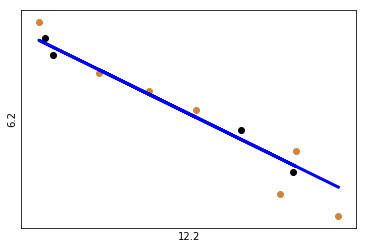

12.2 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------


12.2 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------




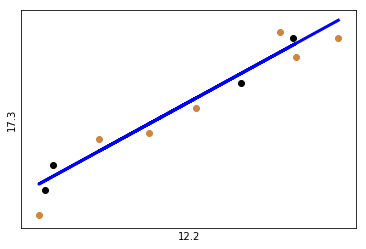

12.2 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------


12.2 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------




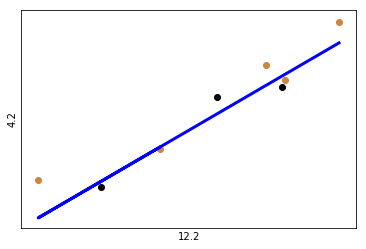

12.2 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------




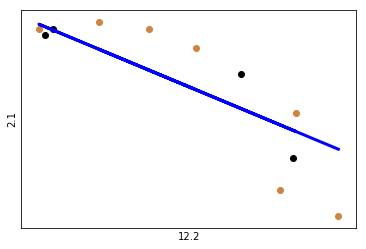

12.2 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------


12.2 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------




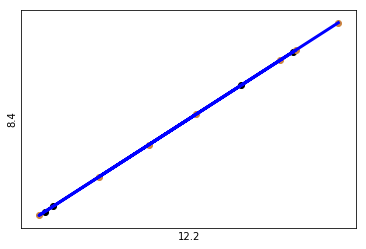

12.2 8.4
MAE: 0.00000
RMSE: 0.00000
R2: 1.000
Coefficient 1.0000000000000002
--------------------------


9.4 12.2
MAE: 0.05996
RMSE: 0.06602
R2: 0.992
Coefficient 3.1415615539913317e-10
--------------------------


17.19 9.4
MAE: 1375313536.67891
RMSE: 1617866995.69782
R2: 0.000
Coefficient 16.76197862503007
--------------------------


17.19 9.c
MAE: 6.04664
RMSE: 6.62347
R2: 0.000
Coefficient 6.209214840822085e-08
--------------------------


17.19 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.218
Coefficient 3.96241069754482e-14
--------------------------


3.3 16.a
MAE: 5.95741
RMSE: 7.71249
R2: nan
Coefficient -2.8148148148148167
--------------------------




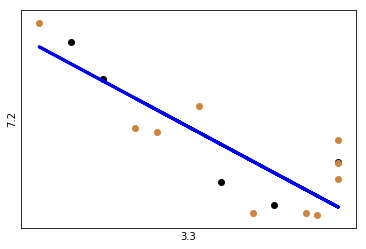

3.3 7.2
MAE: 0.25125
RMSE: 0.27385
R2: 0.583
Coefficient -0.4281557743957035
--------------------------




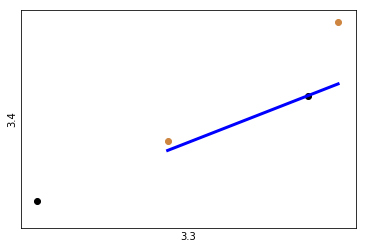

3.3 3.4
MAE: 0.02943
RMSE: 0.03662
R2: nan
Coefficient 0.03259259259259264
--------------------------


3.3 15.1
MAE: 1.74510
RMSE: 2.15919
R2: 0.687
Coefficient -2.6338942307692297
--------------------------




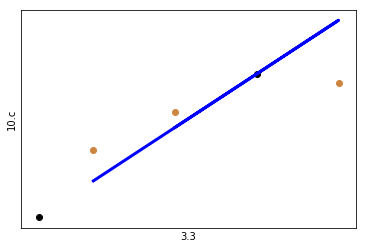

3.3 10.c
MAE: 0.38333
RMSE: 0.43625
R2: 0.000
Coefficient 1.8749999999999984
--------------------------


3.3 8.2
MAE: 1.09224
RMSE: 1.37570
R2: 0.000
Coefficient 0.208990384615385
--------------------------


3.3 17.8
MAE: 1.42098
RMSE: 1.86907
R2: 0.968
Coefficient -10.81375
--------------------------


3.3 6.1
MAE: 2.59709
RMSE: 2.93162
R2: 0.727
Coefficient -3.7497115384615367
--------------------------




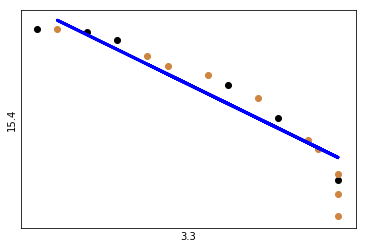

3.3 15.4
MAE: 0.98942
RMSE: 1.34588
R2: 0.835
Coefficient -2.681923076923076
--------------------------




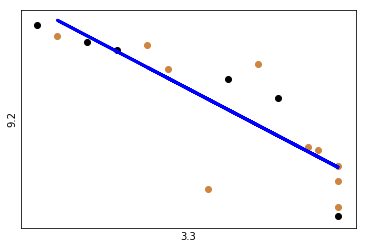

3.3 9.2
MAE: 0.18023
RMSE: 0.25943
R2: 0.614
Coefficient -0.35668269230769195
--------------------------




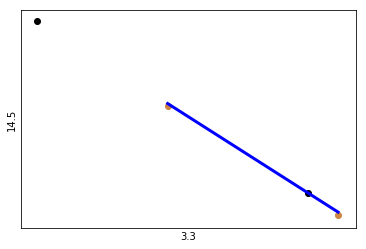

3.3 14.5
MAE: 0.14944
RMSE: 0.15043
R2: nan
Coefficient -3.3444444444444463
--------------------------




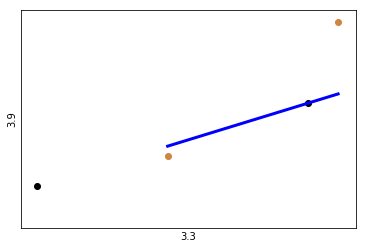

3.3 3.9
MAE: 0.01767
RMSE: 0.02213
R2: nan
Coefficient 0.01333333333333334
--------------------------




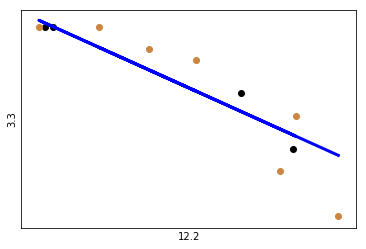

12.2 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------


17.19 12.2
MAE: 0.19643
RMSE: 0.22891
R2: 0.000
Coefficient 4.218661419645584e-09
--------------------------




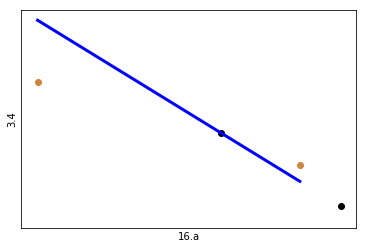

16.a 3.4
MAE: 0.04718
RMSE: 0.05451
R2: nan
Coefficient -0.01157894736842106
--------------------------


16.a 15.1
MAE: 5.76000
RMSE: 7.11059
R2: 0.000
Coefficient -0.0
--------------------------


16.a 8.2
MAE: 2.84167
RMSE: 2.91770
R2: 0.000
Coefficient 0.13000000000000006
--------------------------


16.a 17.8
MAE: 19.47717
RMSE: 24.22986
R2: nan
Coefficient 3.6828947368421048
--------------------------


16.a 6.1
MAE: 3.29500
RMSE: 3.30201
R2: nan
Coefficient 0.9
--------------------------


16.a 15.4
MAE: 5.83500
RMSE: 6.62778
R2: 0.000
Coefficient 0.030000000000001133
--------------------------




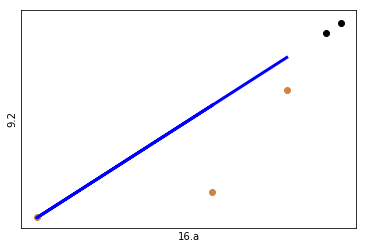

16.a 9.2
MAE: 0.20833
RMSE: 0.27774
R2: 0.053
Coefficient 0.05000000000000068
--------------------------


16.a 14.5
MAE: 3.59067
RMSE: 3.87272
R2: 0.000
Coefficient 0.8200000000000002
--------------------------




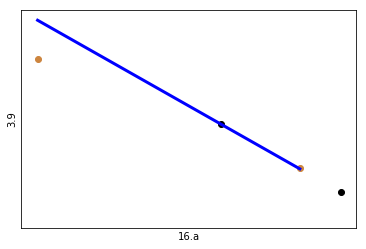

16.a 3.9
MAE: 0.01055
RMSE: 0.01445
R2: nan
Coefficient -0.004736842105263157
--------------------------


12.2 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------


12.2 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.765
Coefficient 2.251603806853583e-05
--------------------------


7.2 15.1
MAE: 2.65733
RMSE: 3.65656
R2: 0.103
Coefficient 3.8741354204586806
--------------------------




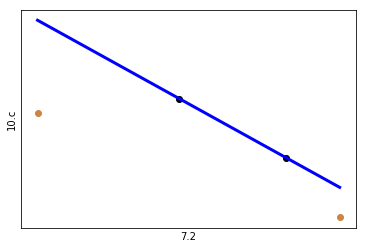

7.2 10.c
MAE: 0.41429
RMSE: 0.46642
R2: nan
Coefficient -1.4285714285714242
--------------------------




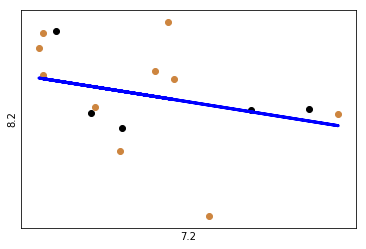

7.2 8.2
MAE: 0.99562
RMSE: 1.26410
R2: 0.143
Coefficient -0.812795777211503
--------------------------


7.2 17.8
MAE: 5.91454
RMSE: 7.77572
R2: 0.451
Coefficient 18.269475791772827
--------------------------


7.2 6.1
MAE: 4.05293
RMSE: 5.01209
R2: 0.201
Coefficient 6.243993447397157
--------------------------


7.2 15.4
MAE: 2.04991
RMSE: 2.90648
R2: 0.231
Coefficient 4.592737531852925
--------------------------




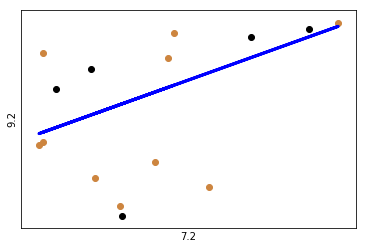

7.2 9.2
MAE: 0.33938
RMSE: 0.41384
R2: 0.019
Coefficient 0.4720604295595195
--------------------------




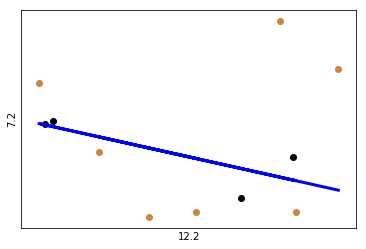

12.2 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------


3.4 15.1
MAE: 2.39938
RMSE: 2.62201
R2: nan
Coefficient -52.84090909090902
--------------------------


3.4 8.2
MAE: 1.22375
RMSE: 1.34218
R2: nan
Coefficient 12.499999999999988
--------------------------


3.4 17.8
MAE: 5.73278
RMSE: 7.26912
R2: nan
Coefficient -318.06818181818153
--------------------------


3.4 6.1
MAE: 3.45250
RMSE: 3.64660
R2: nan
Coefficient -77.72727272727268
--------------------------




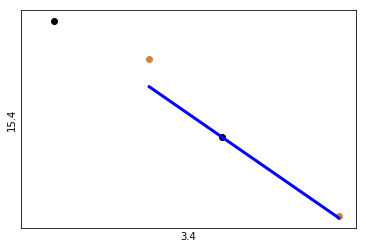

3.4 15.4
MAE: 0.76847
RMSE: 1.01502
R2: nan
Coefficient -69.43181818181809
--------------------------




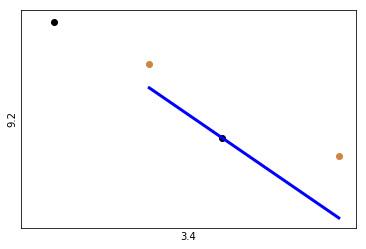

3.4 9.2
MAE: 0.30847
RMSE: 0.33747
R2: nan
Coefficient -9.431818181818173
--------------------------


3.4 14.5
MAE: 2.87006
RMSE: 3.62806
R2: nan
Coefficient -102.61363636363627
--------------------------




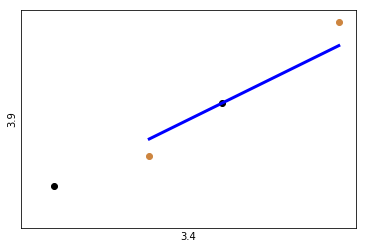

3.4 3.9
MAE: 0.00875
RMSE: 0.00885
R2: nan
Coefficient 0.40909090909090867
--------------------------




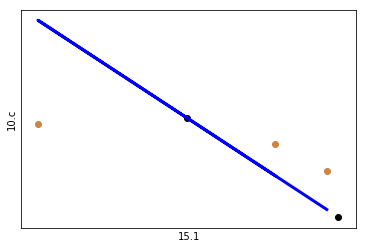

15.1 10.c
MAE: 0.87862
RMSE: 1.00705
R2: 0.000
Coefficient -2.8301886792453153
--------------------------


15.1 8.2
MAE: 1.05290
RMSE: 1.32674
R2: 0.000
Coefficient -0.006426421937253317
--------------------------


15.1 17.8
MAE: 4.57561
RMSE: 4.96867
R2: 0.776
Coefficient 3.281093035129253
--------------------------


15.1 6.1
MAE: 1.05987
RMSE: 1.22626
R2: 0.952
Coefficient 1.4131643456312002
--------------------------




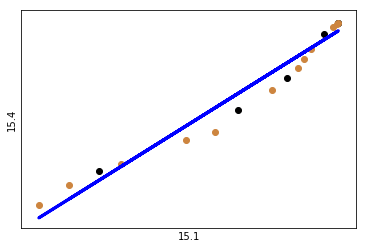

15.1 15.4
MAE: 0.60494
RMSE: 0.69877
R2: 0.961
Coefficient 0.9286220321467337
--------------------------




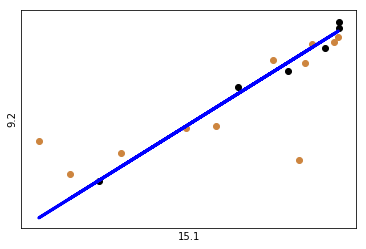

15.1 9.2
MAE: 0.21670
RMSE: 0.34606
R2: 0.353
Coefficient 0.1404745965409438
--------------------------


15.1 14.5
MAE: 8.31333
RMSE: 8.67175
R2: 0.000
Coefficient 0.0
--------------------------




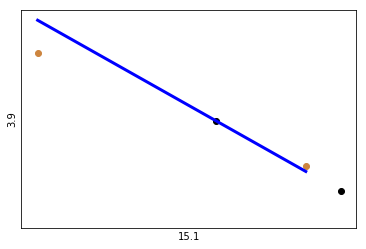

15.1 3.9
MAE: 0.00983
RMSE: 0.01200
R2: nan
Coefficient -0.00774193548387097
--------------------------




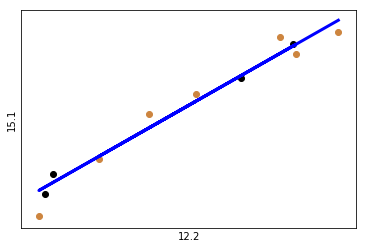

12.2 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------




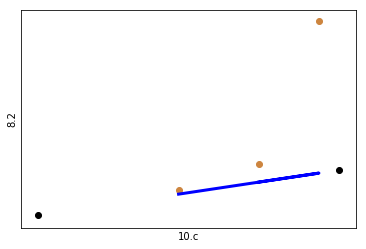

10.c 8.2
MAE: 0.29644
RMSE: 0.45092
R2: 0.000
Coefficient 0.15333333333333327
--------------------------


10.c 17.8
MAE: 1.54333
RMSE: 2.20452
R2: 0.631
Coefficient -5.966666666666667
--------------------------




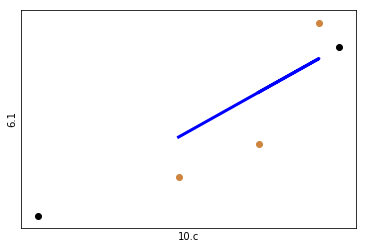

10.c 6.1
MAE: 0.24200
RMSE: 0.24497
R2: 0.580
Coefficient 0.6400000000000005
--------------------------




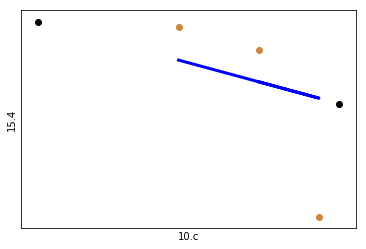

10.c 15.4
MAE: 0.46511
RMSE: 0.55810
R2: 0.245
Coefficient -0.41333333333333633
--------------------------




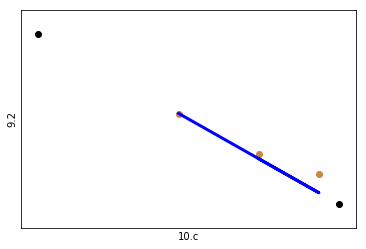

10.c 9.2
MAE: 0.00800
RMSE: 0.01112
R2: 0.801
Coefficient -0.11333333333333326
--------------------------


8.2 17.8
MAE: 11.74453
RMSE: 13.40089
R2: 0.000
Coefficient -4.091144022772886
--------------------------


8.2 6.1
MAE: 5.18259
RMSE: 6.17745
R2: 0.000
Coefficient -0.2954047565950865
--------------------------


8.2 15.4
MAE: 3.21827
RMSE: 3.85630
R2: 0.000
Coefficient -0.643368866998467
--------------------------




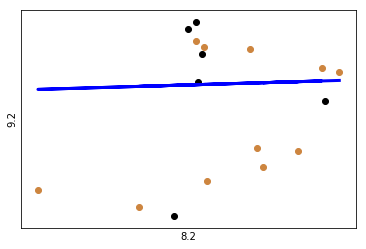

8.2 9.2
MAE: 0.42737
RMSE: 0.49368
R2: 0.000
Coefficient 0.013105550484784536
--------------------------


8.2 14.5
MAE: 17.76436
RMSE: 17.82679
R2: 0.000
Coefficient 6.307692307692304
--------------------------




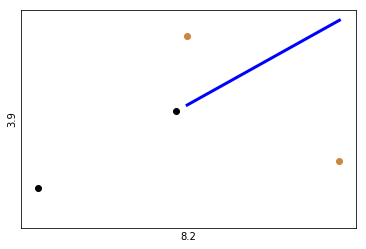

8.2 3.9
MAE: 0.04880
RMSE: 0.05159
R2: nan
Coefficient 0.03272727272727273
--------------------------


12.2 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------


17.8 6.1
MAE: 2.29816
RMSE: 2.52561
R2: 0.797
Coefficient 0.34744662839700846
--------------------------




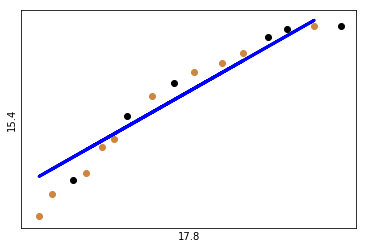

17.8 15.4
MAE: 0.82989
RMSE: 1.00274
R2: 0.908
Coefficient 0.24799591869889184
--------------------------




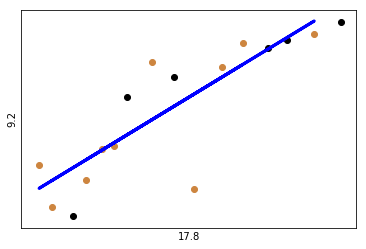

17.8 9.2
MAE: 0.18173
RMSE: 0.25684
R2: 0.622
Coefficient 0.033134823135816095
--------------------------


17.8 14.5
MAE: 1.02057
RMSE: 1.28299
R2: nan
Coefficient 0.32261521972132895
--------------------------




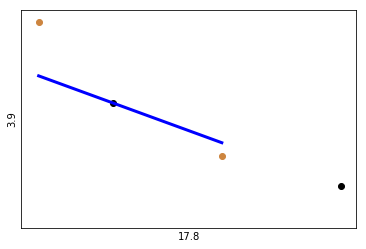

17.8 3.9
MAE: 0.01450
RMSE: 0.01689
R2: nan
Coefficient -0.0012861736334405145
--------------------------


12.2 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




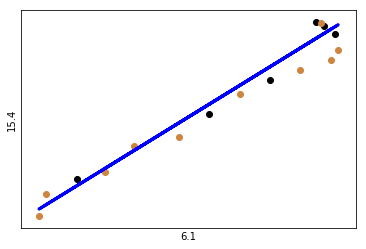

6.1 15.4
MAE: 0.73722
RMSE: 0.87295
R2: 0.931
Coefficient 0.6517383630151858
--------------------------




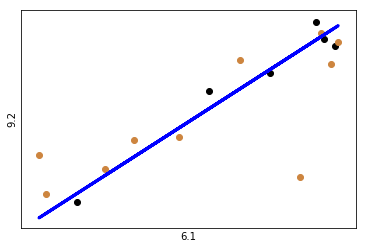

6.1 9.2
MAE: 0.23499
RMSE: 0.34790
R2: 0.306
Coefficient 0.09280584243464102
--------------------------


6.1 14.5
MAE: 6.77728
RMSE: 6.90470
R2: nan
Coefficient 1.3201754385964903
--------------------------




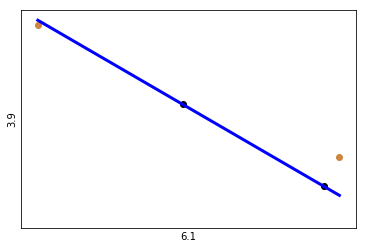

6.1 3.9
MAE: 0.00942
RMSE: 0.01203
R2: nan
Coefficient -0.005263157894736839
--------------------------




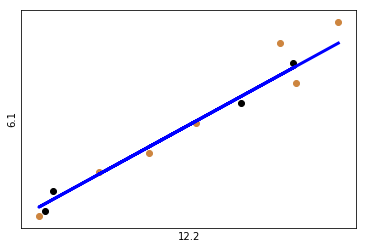

12.2 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------




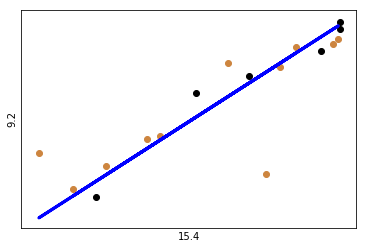

15.4 9.2
MAE: 0.18763
RMSE: 0.29656
R2: 0.525
Coefficient 0.14539266188889807
--------------------------


15.4 14.5
MAE: 159.65000
RMSE: 182.86676
R2: 0.000
Coefficient 27.3333333333323
--------------------------




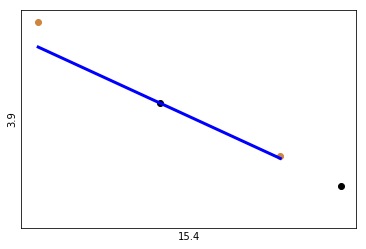

15.4 3.9
MAE: 0.00582
RMSE: 0.00757
R2: nan
Coefficient -0.005891980360065466
--------------------------




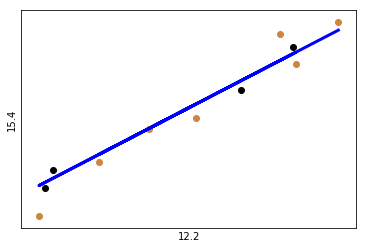

12.2 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------


9.2 14.5
MAE: 3.52200
RMSE: 4.16030
R2: 0.000
Coefficient 16.39999999999978
--------------------------




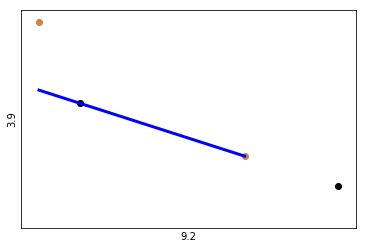

9.2 3.9
MAE: 0.01469
RMSE: 0.02076
R2: nan
Coefficient -0.04337349397590361
--------------------------




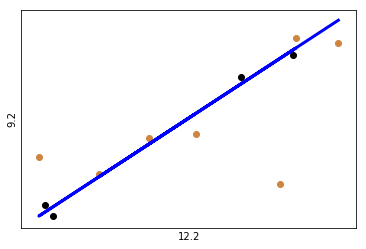

12.2 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------




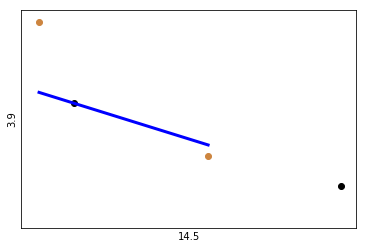

14.5 3.9
MAE: 0.01760
RMSE: 0.02172
R2: nan
Coefficient -0.003986710963455149
--------------------------




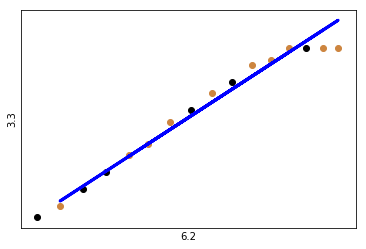

6.2 3.3
MAE: 0.15739
RMSE: 0.21455
R2: 0.947
Coefficient 0.3560437618718067
--------------------------


6.2 16.a
MAE: 4.99514
RMSE: 6.20180
R2: nan
Coefficient -1.085714285714286
--------------------------




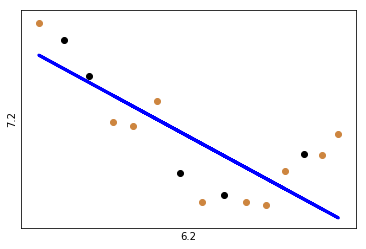

6.2 7.2
MAE: 0.29459
RMSE: 0.33609
R2: 0.372
Coefficient -0.14263380926065206
--------------------------




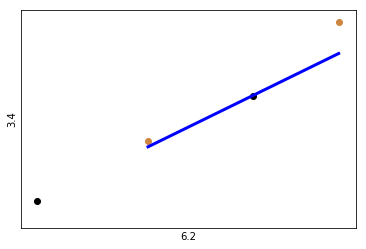

6.2 3.4
MAE: 0.01527
RMSE: 0.01862
R2: nan
Coefficient 0.012571428571428584
--------------------------


6.2 15.1
MAE: 1.35233
RMSE: 1.58624
R2: 0.831
Coefficient -0.9726985260553945
--------------------------




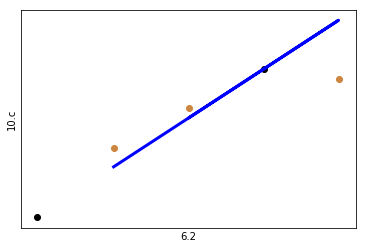

6.2 10.c
MAE: 0.29484
RMSE: 0.36390
R2: 0.000
Coefficient 0.6637168141592915
--------------------------


6.2 8.2
MAE: 1.10410
RMSE: 1.37796
R2: 0.000
Coefficient 0.059712426192334356
--------------------------




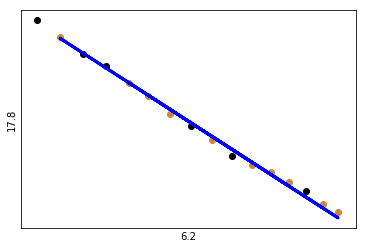

6.2 17.8
MAE: 0.54934
RMSE: 0.63737
R2: 0.996
Coefficient -3.855544961936596
--------------------------


6.2 6.1
MAE: 2.06647
RMSE: 2.27683
R2: 0.835
Coefficient -1.3773117812495397
--------------------------




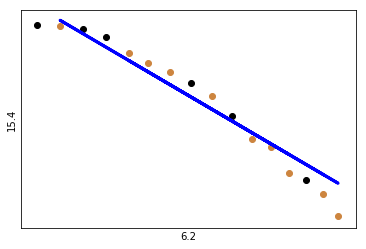

6.2 15.4
MAE: 0.69003
RMSE: 0.82222
R2: 0.938
Coefficient -0.9721132183823421
--------------------------




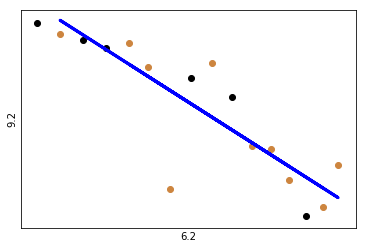

6.2 9.2
MAE: 0.18285
RMSE: 0.26142
R2: 0.608
Coefficient -0.13212308394563627
--------------------------


6.2 14.5
MAE: 1.30300
RMSE: 1.72218
R2: nan
Coefficient -1.29
--------------------------




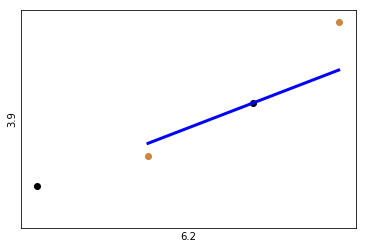

6.2 3.9
MAE: 0.01311
RMSE: 0.01512
R2: nan
Coefficient 0.0051428571428571435
--------------------------


6.2 8.1
MAE: 1.32755
RMSE: 1.77704
R2: 0.000
Coefficient 0.012834435233313207
--------------------------




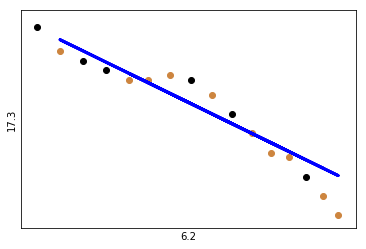

6.2 17.3
MAE: 0.02936
RMSE: 0.03804
R2: 0.879
Coefficient -0.031122539130946956
--------------------------




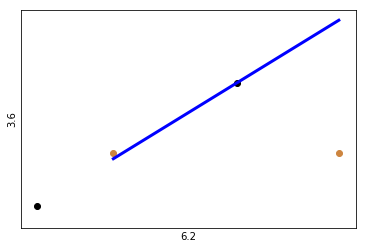

6.2 3.6
MAE: 0.07880
RMSE: 0.10697
R2: nan
Coefficient 0.02550091074681242
--------------------------




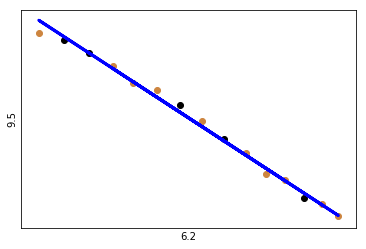

6.2 9.5
MAE: 0.64560
RMSE: 0.89635
R2: 0.991
Coefficient -3.4689276800355158
--------------------------




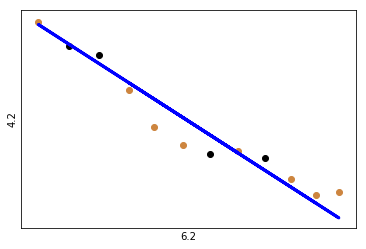

6.2 4.2
MAE: 0.80352
RMSE: 1.02382
R2: 0.897
Coefficient -1.5200732298637945
--------------------------




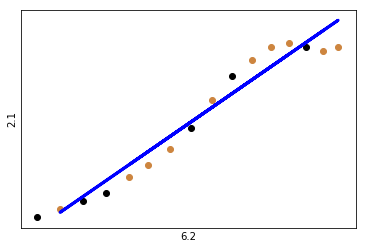

6.2 2.1
MAE: 0.36102
RMSE: 0.39796
R2: 0.930
Coefficient 0.5259486401719848
--------------------------


6.2 14.4
MAE: 3.14004
RMSE: 3.54782
R2: 0.549
Coefficient -1.3928777300967148
--------------------------




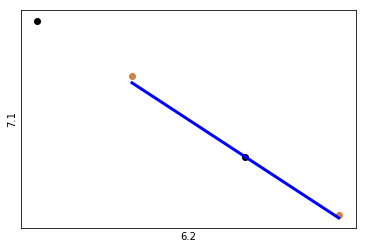

6.2 7.1
MAE: 0.25087
RMSE: 0.26437
R2: nan
Coefficient -1.1137820512820524
--------------------------




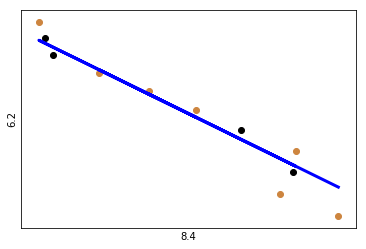

8.4 6.2
MAE: 0.50819
RMSE: 0.62736
R2: 0.904
Coefficient -2.232834890965733
--------------------------


9.4 8.4
MAE: 0.05996
RMSE: 0.06602
R2: 0.992
Coefficient 3.1415615539913317e-10
--------------------------


9.4 9.c
MAE: 5.68008
RMSE: 8.80579
R2: 0.626
Coefficient 4.610270020263794e-09
--------------------------


9.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.833
Coefficient 4.84725936945202e-15
--------------------------


8.1 3.3
MAE: 1.01734
RMSE: 1.11276
R2: 0.000
Coefficient 0.10636134844863376
--------------------------


8.1 16.a
MAE: 7.54778
RMSE: 7.68040
R2: nan
Coefficient -8.444444444444446
--------------------------




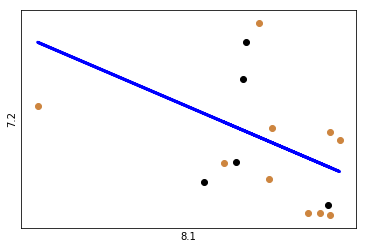

8.1 7.2
MAE: 0.36626
RMSE: 0.41235
R2: 0.054
Coefficient -0.1546675776643934
--------------------------




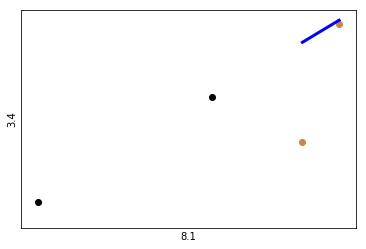

8.1 3.4
MAE: 0.04374
RMSE: 0.05942
R2: nan
Coefficient 0.09777777777777785
--------------------------


8.1 15.1
MAE: 3.32083
RMSE: 4.32836
R2: 0.000
Coefficient -0.10284609232743368
--------------------------




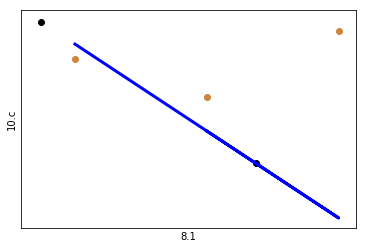

8.1 10.c
MAE: 0.83333
RMSE: 1.16527
R2: 0.000
Coefficient -3.4090909090909096
--------------------------




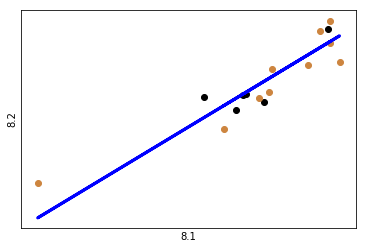

8.1 8.2
MAE: 0.49894
RMSE: 0.56971
R2: 0.826
Coefficient 0.8644141315103401
--------------------------


8.1 17.8
MAE: 11.05906
RMSE: 12.44652
R2: 0.000
Coefficient -1.1600977765327285
--------------------------


8.1 6.1
MAE: 4.92029
RMSE: 5.99257
R2: 0.000
Coefficient -0.4672805562960599
--------------------------


8.1 15.4
MAE: 3.16045
RMSE: 3.81108
R2: 0.000
Coefficient -0.3101693919691312
--------------------------




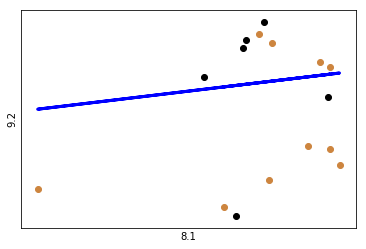

8.1 9.2
MAE: 0.43036
RMSE: 0.49056
R2: 0.000
Coefficient 0.038875660240103305
--------------------------


8.1 14.5
MAE: 7.35883
RMSE: 7.60187
R2: nan
Coefficient -10.033333333333333
--------------------------




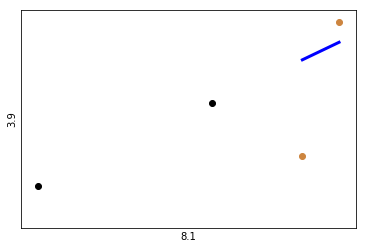

8.1 3.9
MAE: 0.02520
RMSE: 0.03018
R2: nan
Coefficient 0.04
--------------------------




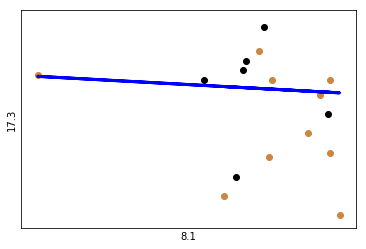

8.1 17.3
MAE: 0.09633
RMSE: 0.12881
R2: 0.000
Coefficient -0.005467172116518579
--------------------------




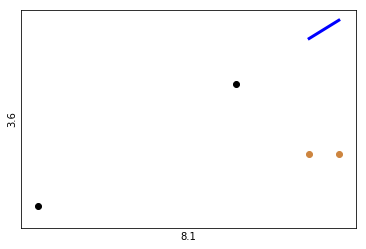

8.1 3.6
MAE: 0.14228
RMSE: 0.14267
R2: nan
Coefficient 0.11023622047244104
--------------------------


8.1 9.5
MAE: 8.64530
RMSE: 9.79841
R2: 0.000
Coefficient -1.7342478207685397
--------------------------


8.1 4.2
MAE: 3.29238
RMSE: 3.85719
R2: 0.000
Coefficient -0.8517221666428488
--------------------------


8.1 2.1
MAE: 1.59131
RMSE: 1.68858
R2: 0.000
Coefficient 0.3785000067774865
--------------------------


8.1 14.4
MAE: 3.47825
RMSE: 4.60346
R2: 0.241
Coefficient -0.9672313734685504
--------------------------


8.1 7.1
MAE: 4.51175
RMSE: 5.34441
R2: nan
Coefficient -6.950000000000001
--------------------------


8.4 8.1
MAE: 1.82093
RMSE: 2.19188
R2: 0.000
Coefficient 0.2876012461059194
--------------------------


17.19 8.4
MAE: 0.19643
RMSE: 0.22891
R2: 0.000
Coefficient 4.218661419645584e-09
--------------------------


8.4 9.c
MAE: 7.58750
RMSE: 10.21922
R2: 0.264
Coefficient 16.44735202492212
--------------------------


8.4 17.2
MAE: 0.00001
RMSE: 0.00001
R2: 0.765
Coe

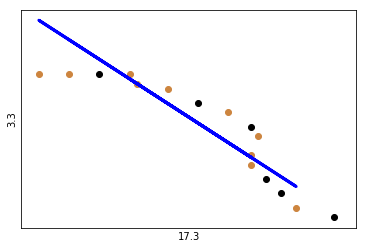

17.3 3.3
MAE: 0.40856
RMSE: 0.53294
R2: 0.674
Coefficient -10.267441860465116
--------------------------


17.3 16.a
MAE: 3.51364
RMSE: 4.20696
R2: nan
Coefficient 34.545454545454554
--------------------------




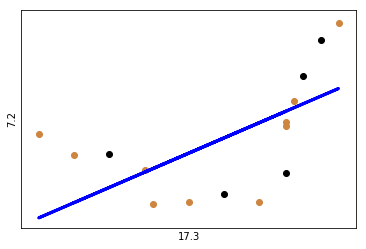

17.3 7.2
MAE: 0.31355
RMSE: 0.38817
R2: 0.162
Coefficient 3.0173319327731165
--------------------------




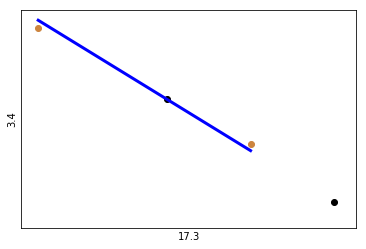

17.3 3.4
MAE: 0.00650
RMSE: 0.00652
R2: nan
Coefficient -0.40000000000000036
--------------------------




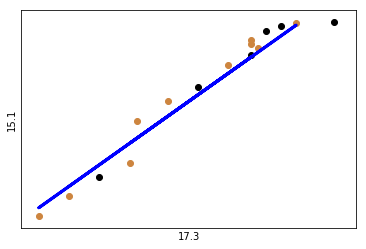

17.3 15.1
MAE: 0.67168
RMSE: 0.74594
R2: 0.963
Coefficient 31.423837209302327
--------------------------




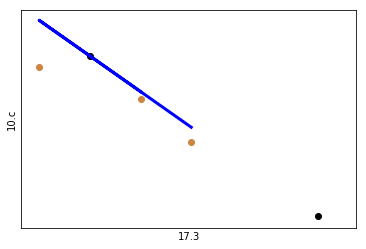

17.3 10.c
MAE: 0.21111
RMSE: 0.26458
R2: 0.149
Coefficient -16.666666666666668
--------------------------


17.3 8.2
MAE: 1.12294
RMSE: 1.37848
R2: 0.000
Coefficient -0.8738372093023267
--------------------------


17.3 17.8
MAE: 3.45987
RMSE: 4.24990
R2: 0.836
Coefficient 111.90988372093022
--------------------------


17.3 6.1
MAE: 1.10563
RMSE: 1.58229
R2: 0.920
Coefficient 43.59767441860465
--------------------------




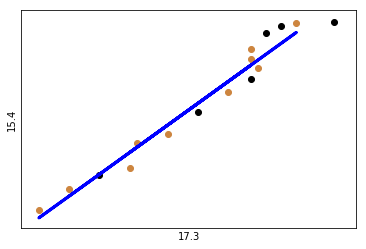

17.3 15.4
MAE: 0.51150
RMSE: 0.54893
R2: 0.973
Coefficient 29.62209302325582
--------------------------




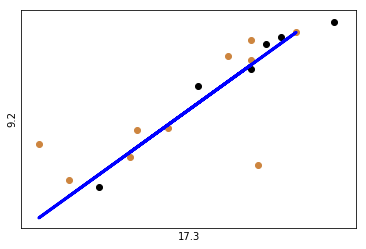

17.3 9.2
MAE: 0.21533
RMSE: 0.33611
R2: 0.353
Coefficient 4.2872093023255795
--------------------------


17.3 14.5
MAE: 2.92136
RMSE: 4.10676
R2: nan
Coefficient 41.04545454545455
--------------------------




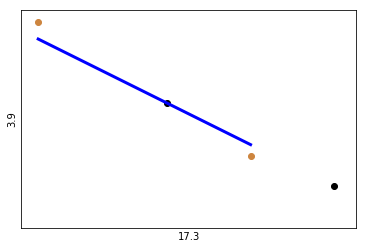

17.3 3.9
MAE: 0.00609
RMSE: 0.00619
R2: nan
Coefficient -0.16363636363636364
--------------------------




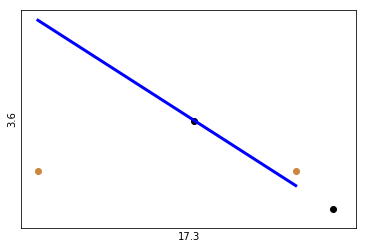

17.3 3.6
MAE: 0.13067
RMSE: 0.16952
R2: nan
Coefficient -0.9333333333333348
--------------------------


17.3 9.5
MAE: 2.24904
RMSE: 3.05319
R2: 0.897
Coefficient 101.67415966386557
--------------------------


17.3 4.2
MAE: 2.17038
RMSE: 2.50841
R2: 0.382
Coefficient 60.0836363636364
--------------------------




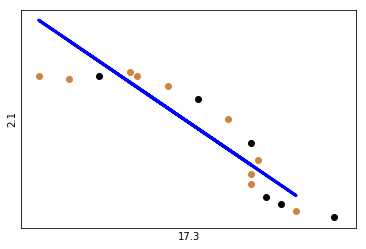

17.3 2.1
MAE: 0.65053
RMSE: 0.77669
R2: 0.732
Coefficient -15.267441860465114
--------------------------


17.3 14.4
MAE: 5.76621
RMSE: 6.15249
R2: 0.000
Coefficient 55.35483870967741
--------------------------


17.3 7.1
MAE: 2.19853
RMSE: 2.84868
R2: nan
Coefficient 40.88235294117649
--------------------------




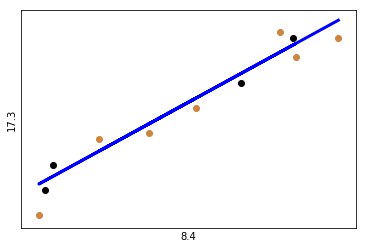

8.4 17.3
MAE: 0.02570
RMSE: 0.02814
R2: 0.915
Coefficient 0.1233021806853583
--------------------------




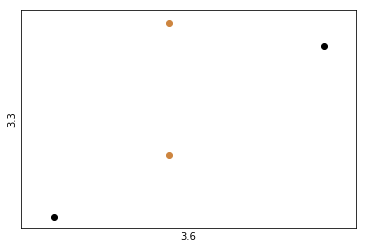

3.6 3.3
MAE: 0.85000
RMSE: 1.10569
R2: nan
Coefficient 15.714285714285696
--------------------------




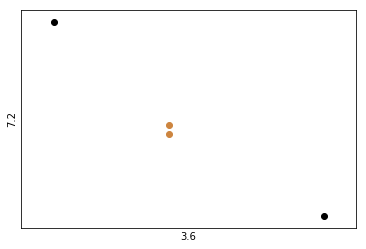

3.6 7.2
MAE: 0.16143
RMSE: 0.16419
R2: nan
Coefficient -9.14285714285714
--------------------------


3.6 15.1
MAE: 5.01500
RMSE: 6.53913
R2: nan
Coefficient -31.642857142857107
--------------------------


3.6 8.2
MAE: 1.17500
RMSE: 1.32161
R2: nan
Coefficient 5.999999999999995
--------------------------


3.6 17.8
MAE: 11.27500
RMSE: 15.18067
R2: nan
Coefficient -152.99999999999983
--------------------------


3.6 6.1
MAE: 7.30000
RMSE: 8.25904
R2: nan
Coefficient -51.78571428571423
--------------------------


3.6 15.4
MAE: 4.10000
RMSE: 5.32726
R2: nan
Coefficient -42.14285714285709
--------------------------




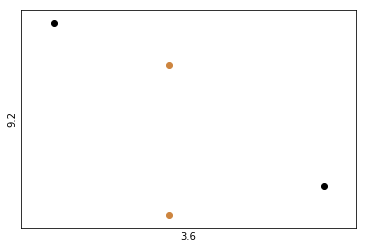

3.6 9.2
MAE: 0.33000
RMSE: 0.38887
R2: nan
Coefficient -5.071428571428573
--------------------------


3.6 9.5
MAE: 10.62900
RMSE: 14.43464
R2: nan
Coefficient -128.69285714285698
--------------------------


3.6 2.1
MAE: 1.45000
RMSE: 1.68077
R2: nan
Coefficient 24.999999999999975
--------------------------




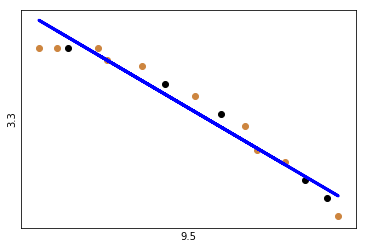

9.5 3.3
MAE: 0.20378
RMSE: 0.24968
R2: 0.928
Coefficient -0.10072705895926859
--------------------------




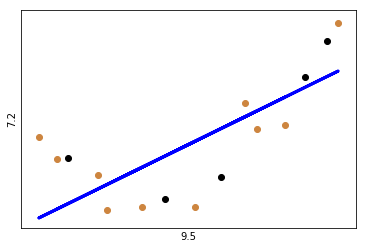

9.5 7.2
MAE: 0.29622
RMSE: 0.33972
R2: 0.358
Coefficient 0.03876326137194816
--------------------------


9.5 15.1
MAE: 1.08138
RMSE: 1.23761
R2: 0.897
Coefficient 0.3368410988296458
--------------------------




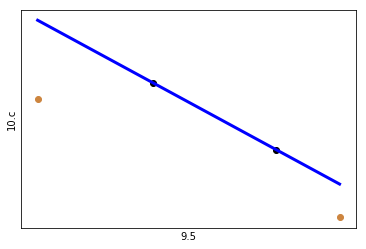

9.5 10.c
MAE: 0.33347
RMSE: 0.36098
R2: nan
Coefficient -0.18885741265344722
--------------------------


9.5 8.2
MAE: 1.11328
RMSE: 1.37089
R2: 0.000
Coefficient -0.007196786356334331
--------------------------


9.5 17.8
MAE: 1.05994
RMSE: 1.39741
R2: 0.982
Coefficient 1.0784372735633556
--------------------------


9.5 6.1
MAE: 1.35809
RMSE: 1.52568
R2: 0.926
Coefficient 0.49955845503585816
--------------------------




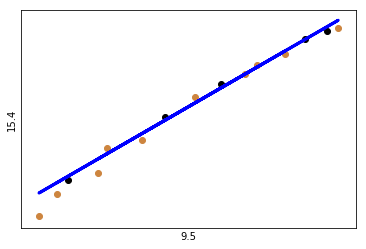

9.5 15.4
MAE: 0.43984
RMSE: 0.55482
R2: 0.972
Coefficient 0.3213717026296678
--------------------------




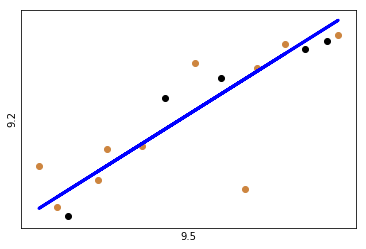

9.5 9.2
MAE: 0.17996
RMSE: 0.27878
R2: 0.555
Coefficient 0.043547147047206344
--------------------------


9.5 4.2
MAE: 1.13402
RMSE: 1.30310
R2: 0.833
Coefficient 0.4642092614228206
--------------------------




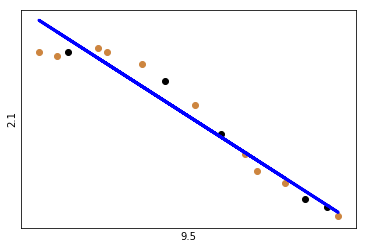

9.5 2.1
MAE: 0.33093
RMSE: 0.40300
R2: 0.928
Coefficient -0.16103895553642691
--------------------------


9.5 14.4
MAE: 3.37257
RMSE: 3.64953
R2: 0.523
Coefficient 0.42930941636474024
--------------------------




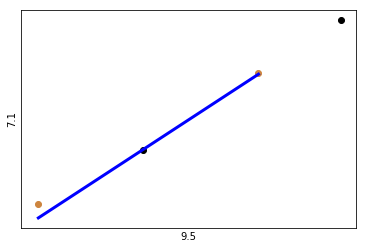

9.5 7.1
MAE: 0.39252
RMSE: 0.52089
R2: nan
Coefficient 0.36385529553426565
--------------------------


8.4 9.5
MAE: 1.72828
RMSE: 2.04544
R2: 0.922
Coefficient 8.490554517133955
--------------------------




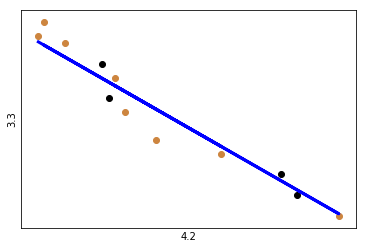

4.2 3.3
MAE: 0.20218
RMSE: 0.24328
R2: 0.929
Coefficient -0.24665117465019443
--------------------------




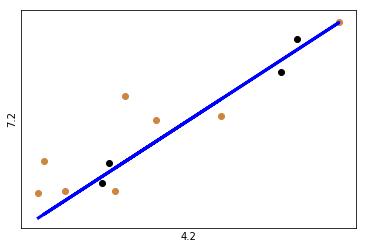

4.2 7.2
MAE: 0.22765
RMSE: 0.28641
R2: 0.632
Coefficient 0.16371969157402538
--------------------------


4.2 15.1
MAE: 1.31510
RMSE: 1.85422
R2: 0.505
Coefficient 0.4136045556279566
--------------------------


4.2 10.c
MAE: 1.06071
RMSE: 1.15931
R2: nan
Coefficient -0.7142857142857121
--------------------------


4.2 8.2
MAE: 1.02576
RMSE: 1.45518
R2: 0.000
Coefficient -0.15570267187869577
--------------------------


4.2 17.8
MAE: 1.76710
RMSE: 2.37284
R2: 0.933
Coefficient 2.5726239333865233
--------------------------


4.2 6.1
MAE: 2.59359
RMSE: 2.94380
R2: 0.547
Coefficient 0.7371296460401463
--------------------------


4.2 15.4
MAE: 1.03600
RMSE: 1.29114
R2: 0.755
Coefficient 0.586665577349942
--------------------------




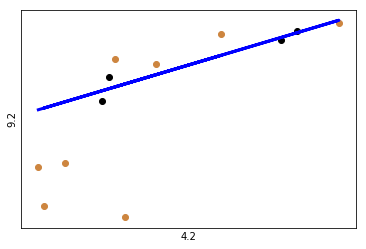

4.2 9.2
MAE: 0.27621
RMSE: 0.35783
R2: 0.197
Coefficient 0.04772788516844766
--------------------------




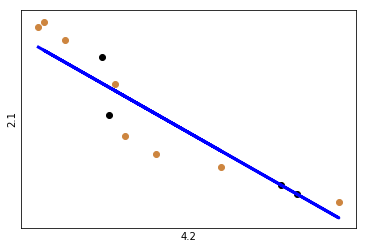

4.2 2.1
MAE: 0.54084
RMSE: 0.59714
R2: 0.840
Coefficient -0.38599367098198595
--------------------------


4.2 14.4
MAE: 14.80011
RMSE: 18.12337
R2: 0.000
Coefficient 5.739130434782508
--------------------------




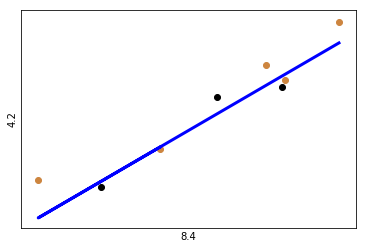

8.4 4.2
MAE: 0.41259
RMSE: 0.51328
R2: 0.858
Coefficient 2.470487215367005
--------------------------




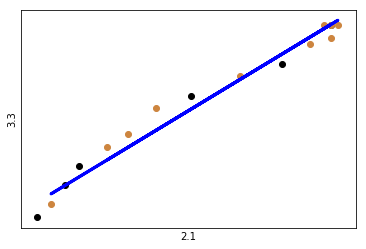

2.1 3.3
MAE: 0.14433
RMSE: 0.17357
R2: 0.965
Coefficient 0.6626389038731254
--------------------------


2.1 16.a
MAE: 5.59103
RMSE: 7.85991
R2: nan
Coefficient -1.94871794871795
--------------------------




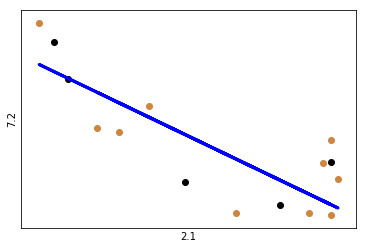

2.1 7.2
MAE: 0.24841
RMSE: 0.27708
R2: 0.573
Coefficient -0.26175139275766074
--------------------------




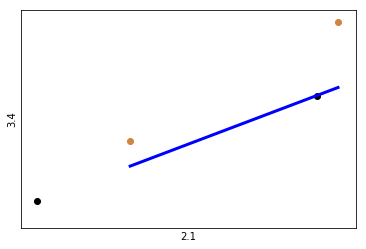

2.1 3.4
MAE: 0.03745
RMSE: 0.04104
R2: nan
Coefficient 0.022564102564102594
--------------------------


2.1 15.1
MAE: 1.55720
RMSE: 2.05813
R2: 0.716
Coefficient -1.8009278239292261
--------------------------




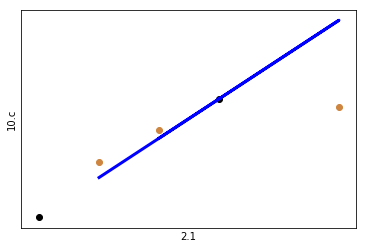

2.1 10.c
MAE: 0.46667
RMSE: 0.64807
R2: 0.000
Coefficient 2.5000000000000018
--------------------------


2.1 8.2
MAE: 1.08193
RMSE: 1.36678
R2: 0.000
Coefficient 0.16561657136692207
--------------------------


2.1 17.8
MAE: 2.52283
RMSE: 2.74324
R2: 0.932
Coefficient -7.165087927500267
--------------------------


2.1 6.1
MAE: 2.13427
RMSE: 2.53772
R2: 0.795
Coefficient -2.600442334663932
--------------------------




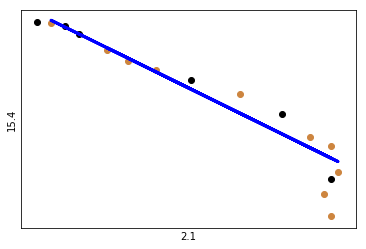

2.1 15.4
MAE: 0.83853
RMSE: 1.25196
R2: 0.857
Coefficient -1.82322796418168
--------------------------




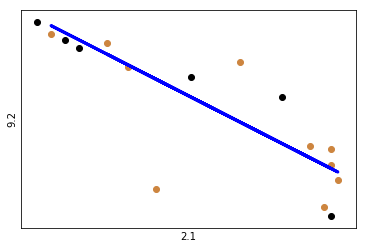

2.1 9.2
MAE: 0.18532
RMSE: 0.28641
R2: 0.530
Coefficient -0.23983169705469823
--------------------------




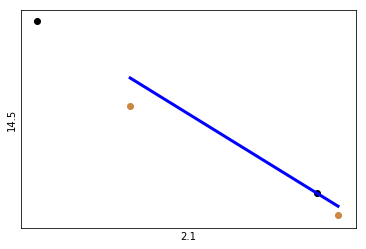

2.1 14.5
MAE: 0.97269
RMSE: 1.09245
R2: nan
Coefficient -2.3153846153846165
--------------------------




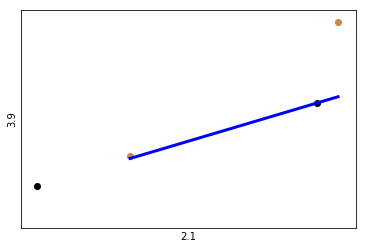

2.1 3.9
MAE: 0.01662
RMSE: 0.02280
R2: nan
Coefficient 0.009230769230769235
--------------------------


2.1 14.4
MAE: 2.99505
RMSE: 3.29122
R2: 0.738
Coefficient -1.664513618677043
--------------------------


2.1 7.1
MAE: 1.57514
RMSE: 1.76726
R2: nan
Coefficient -1.8783783783783794
--------------------------




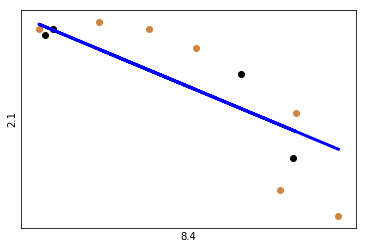

8.4 2.1
MAE: 0.58667
RMSE: 0.67395
R2: 0.670
Coefficient -0.9221183800623053
--------------------------




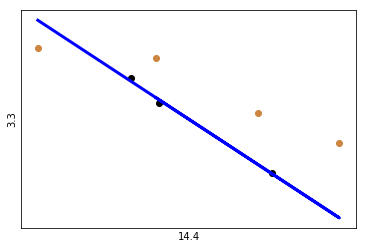

14.4 3.3
MAE: 0.97484
RMSE: 1.03541
R2: 0.000
Coefficient -0.28138528138528157
--------------------------




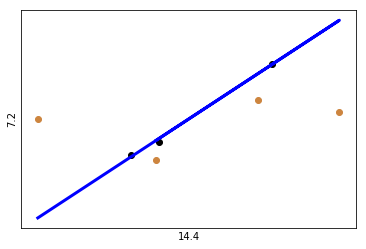

14.4 7.2
MAE: 0.79911
RMSE: 0.93748
R2: 0.000
Coefficient 0.18885281385281408
--------------------------


14.4 15.1
MAE: 3.17385
RMSE: 3.63093
R2: 0.228
Coefficient 0.4821428571428563
--------------------------


14.4 8.2
MAE: 1.45557
RMSE: 1.62939
R2: 0.000
Coefficient -0.20238095238095233
--------------------------


14.4 17.8
MAE: 8.26737
RMSE: 9.69319
R2: 0.015
Coefficient 2.89177489177489
--------------------------


14.4 6.1
MAE: 3.63884
RMSE: 4.26371
R2: 0.511
Coefficient 0.7711038961038954
--------------------------


14.4 15.4
MAE: 2.81170
RMSE: 2.86120
R2: 0.322
Coefficient 0.6617965367965364
--------------------------




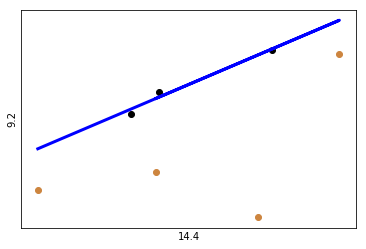

14.4 9.2
MAE: 0.46524
RMSE: 0.55680
R2: 0.000
Coefficient 0.05465367965367972
--------------------------


8.4 14.4
MAE: 3.14000
RMSE: 3.57269
R2: 0.279
Coefficient 3.666666666666673
--------------------------




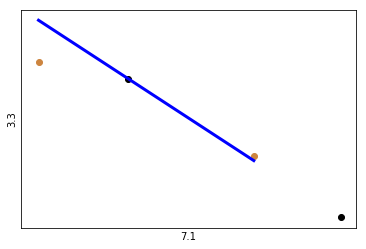

7.1 3.3
MAE: 0.41799
RMSE: 0.53853
R2: nan
Coefficient -0.35971223021582704
--------------------------




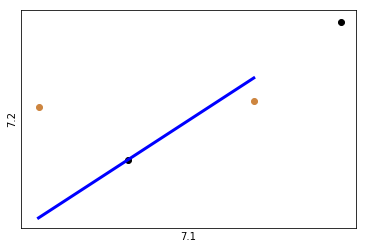

7.1 7.2
MAE: 0.69022
RMSE: 0.82421
R2: nan
Coefficient 0.20431654676258965
--------------------------


7.1 15.1
MAE: 2.67683
RMSE: 3.37348
R2: nan
Coefficient 0.6633093525179855
--------------------------


7.1 8.2
MAE: 1.09698
RMSE: 1.34408
R2: nan
Coefficient -0.139568345323741
--------------------------


7.1 17.8
MAE: 1.26791
RMSE: 1.26793
R2: nan
Coefficient 3.558273381294964
--------------------------


7.1 6.1
MAE: 3.71921
RMSE: 3.73246
R2: nan
Coefficient 1.0158273381294967
--------------------------


7.1 15.4
MAE: 1.02133
RMSE: 1.15573
R2: nan
Coefficient 0.8733812949640288
--------------------------




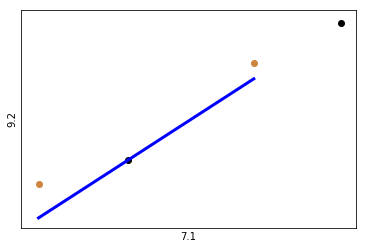

7.1 9.2
MAE: 0.13687
RMSE: 0.14585
R2: nan
Coefficient 0.10791366906474842
--------------------------




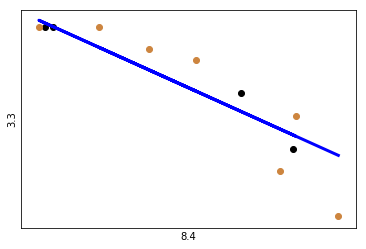

8.4 3.3
MAE: 0.25943
RMSE: 0.29880
R2: 0.769
Coefficient -0.5775700934579425
--------------------------




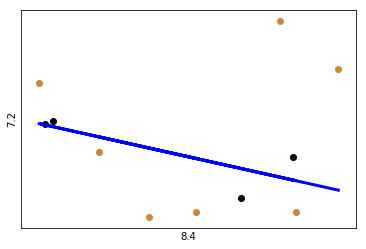

8.4 7.2
MAE: 0.29162
RMSE: 0.35259
R2: 0.000
Coefficient -0.13333333333333353
--------------------------




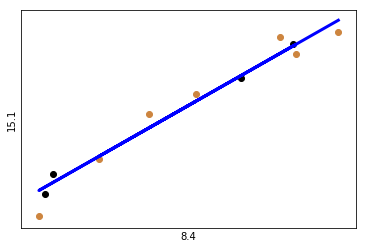

8.4 15.1
MAE: 0.68818
RMSE: 0.77889
R2: 0.949
Coefficient 4.436137071651092
--------------------------


8.4 8.2
MAE: 1.32384
RMSE: 1.65040
R2: 0.000
Coefficient 0.9172585669781937
--------------------------


8.4 17.8
MAE: 2.10170
RMSE: 2.72705
R2: 0.859
Coefficient 7.3968224299065435
--------------------------




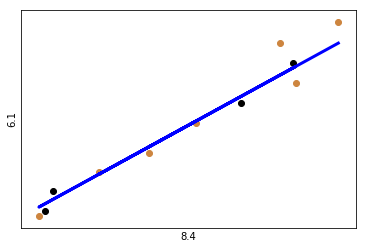

8.4 6.1
MAE: 0.94574
RMSE: 1.23218
R2: 0.937
Coefficient 5.901682242990654
--------------------------




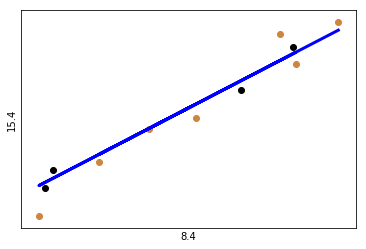

8.4 15.4
MAE: 0.59433
RMSE: 0.72947
R2: 0.931
Coefficient 3.138193146417447
--------------------------




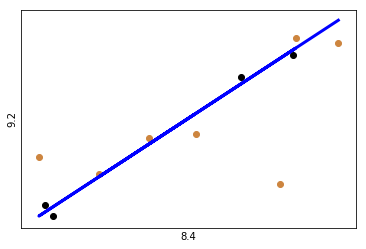

8.4 9.2
MAE: 0.20548
RMSE: 0.31303
R2: 0.052
Coefficient 0.5396261682242991
--------------------------


9.4 3.3
MAE: 0.27585
RMSE: 0.33035
R2: 0.875
Coefficient -3.068140209204522e-10
--------------------------


9.4 7.2
MAE: 0.34063
RMSE: 0.37685
R2: 0.210
Coefficient 1.0985963075886355e-10
--------------------------


9.4 15.1
MAE: 0.85686
RMSE: 1.03339
R2: 0.928
Coefficient 1.0743549115940195e-09
--------------------------


9.4 10.c
MAE: 0.24510
RMSE: 0.24728
R2: nan
Coefficient -7.456287514446561e-10
--------------------------


9.4 8.2
MAE: 1.12383
RMSE: 1.37377
R2: 0.000
Coefficient 7.272512504957432e-12
--------------------------


9.4 17.8
MAE: 1.88643
RMSE: 2.33011
R2: 0.951
Coefficient 3.2917218498602417e-09
--------------------------


9.4 6.1
MAE: 1.20544
RMSE: 1.46533
R2: 0.932
Coefficient 1.5783330596604616e-09
--------------------------


9.4 15.4
MAE: 0.50560
RMSE: 0.60789
R2: 0.966
Coefficient 1.001923601273536e-09
--------------------------


9.4 9.2
MAE: 0.13987
RM

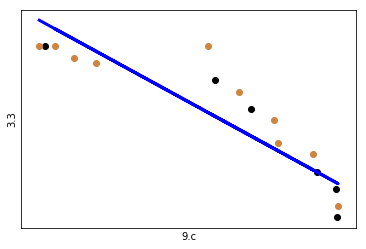

9.c 3.3
MAE: 0.44112
RMSE: 0.52286
R2: 0.686
Coefficient -0.07229761093257901
--------------------------


9.c 16.a
MAE: 7.99590
RMSE: 10.79463
R2: nan
Coefficient 0.23794614902943026
--------------------------




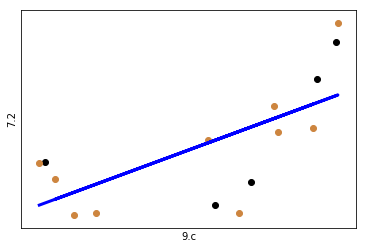

9.c 7.2
MAE: 0.24034
RMSE: 0.30171
R2: 0.494
Coefficient 0.02078693256221196
--------------------------




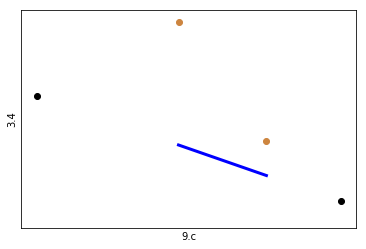

9.c 3.4
MAE: 0.06529
RMSE: 0.07494
R2: nan
Coefficient -0.002755165936130247
--------------------------


9.c 15.1
MAE: 1.56451
RMSE: 2.64330
R2: 0.531
Coefficient 0.23290574568597977
--------------------------




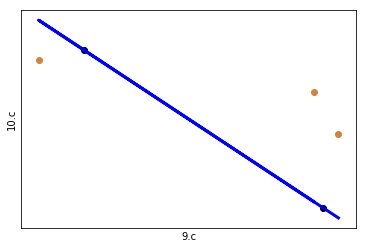

9.c 10.c
MAE: 0.74103
RMSE: 0.78947
R2: 0.000
Coefficient -0.5769230769230781
--------------------------


9.c 8.2
MAE: 1.14099
RMSE: 1.38874
R2: 0.000
Coefficient 0.000799906624019251
--------------------------


9.c 17.8
MAE: 5.12404
RMSE: 6.59333
R2: 0.605
Coefficient 0.7835731874291905
--------------------------


9.c 6.1
MAE: 2.18015
RMSE: 3.24094
R2: 0.666
Coefficient 0.3293396872396318
--------------------------


9.c 15.4
MAE: 1.11387
RMSE: 2.06564
R2: 0.612
Coefficient 0.21801039753430212
--------------------------




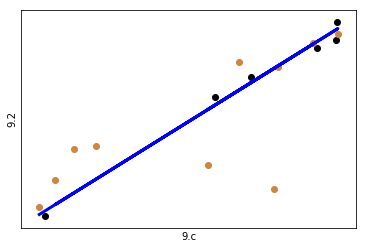

9.c 9.2
MAE: 0.21586
RMSE: 0.31659
R2: 0.426
Coefficient 0.03151149774714154
--------------------------


9.c 14.5
MAE: 3.83006
RMSE: 4.13379
R2: nan
Coefficient 0.2827175954915466
--------------------------




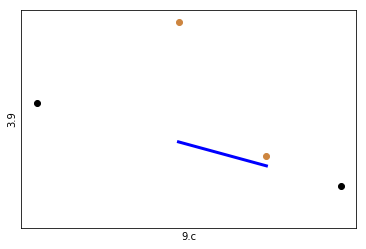

9.c 3.9
MAE: 0.02801
RMSE: 0.03675
R2: nan
Coefficient -0.0011271133375078274
--------------------------


9.c 6.2
MAE: 1.31774
RMSE: 1.75363
R2: 0.609
Coefficient -0.2082308200189885
--------------------------


9.c 8.1
MAE: 1.34232
RMSE: 1.79463
R2: 0.000
Coefficient 0.0015360010994210254
--------------------------




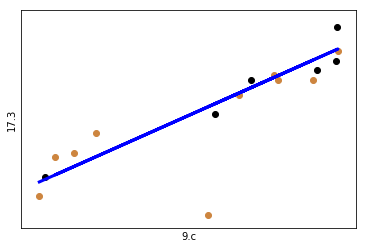

9.c 17.3
MAE: 0.04306
RMSE: 0.07605
R2: 0.517
Coefficient 0.006942870360333823
--------------------------




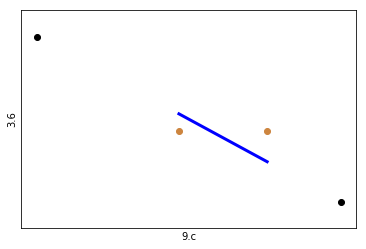

9.c 3.6
MAE: 0.02029
RMSE: 0.02112
R2: nan
Coefficient -0.004396984924623117
--------------------------


9.c 9.5
MAE: 3.45523
RMSE: 5.42838
R2: 0.673
Coefficient 0.6546255365835474
--------------------------


9.c 4.2
MAE: 3.58122
RMSE: 4.74256
R2: 0.000
Coefficient 0.45967038429318446
--------------------------




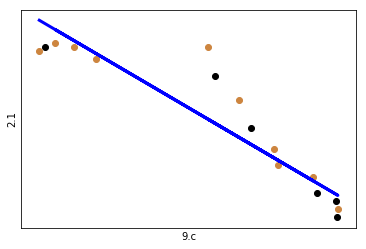

9.c 2.1
MAE: 0.49060
RMSE: 0.70419
R2: 0.780
Coefficient -0.10912360039152393
--------------------------


9.c 14.4
MAE: 5.13854
RMSE: 5.71997
R2: 0.000
Coefficient 0.42130776947244125
--------------------------


9.c 7.1
MAE: 3.64106
RMSE: 4.43154
R2: nan
Coefficient 0.2164434755527874
--------------------------


17.2 9.c
MAE: 7.54621
RMSE: 11.74624
R2: 0.335
Coefficient 796989.7565420856
--------------------------


17.2 3.1
MAE: 8.11197
RMSE: 10.25469
R2: nan
Coefficient -442895.6765385244
--------------------------


17.2 3.3
MAE: 0.47122
RMSE: 0.62980
R2: 0.544
Coefficient -58236.87383265679
--------------------------


17.2 16.a
MAE: 7.34509
RMSE: 8.97269
R2: 0.000
Coefficient 84937.30352939968
--------------------------


17.2 7.2
MAE: 0.33265
RMSE: 0.39545
R2: 0.130
Coefficient 14635.427761271036
--------------------------


17.2 3.4
MAE: 0.09437
RMSE: 0.12716
R2: nan
Coefficient -5413.1693799153045
--------------------------


17.2 15.1
MAE: 1.34203
RMSE: 1.47086
R2: 0.857
Co

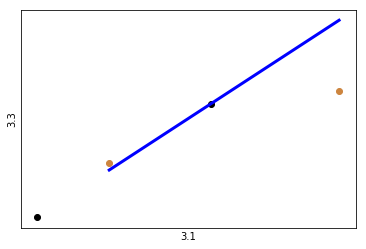

3.1 3.3
MAE: 0.93125
RMSE: 1.19964
R2: nan
Coefficient 0.37500000000000006
--------------------------


3.1 16.a
MAE: 3.33611
RMSE: 4.33583
R2: nan
Coefficient -1.055555555555556
--------------------------




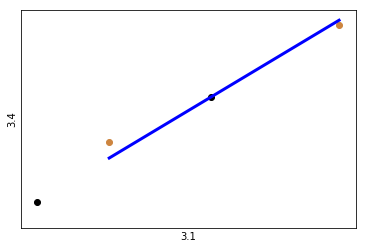

3.1 3.4
MAE: 0.00856
RMSE: 0.00980
R2: nan
Coefficient 0.012222222222222235
--------------------------


3.1 15.1
MAE: 1.94729
RMSE: 2.34681
R2: nan
Coefficient -0.6458333333333333
--------------------------


3.1 8.2
MAE: 1.33069
RMSE: 1.46425
R2: nan
Coefficient 0.15277777777777782
--------------------------


3.1 17.8
MAE: 7.19063
RMSE: 8.33400
R2: nan
Coefficient -3.887500000000001
--------------------------


3.1 6.1
MAE: 2.78750
RMSE: 2.90072
R2: nan
Coefficient -0.9500000000000006
--------------------------




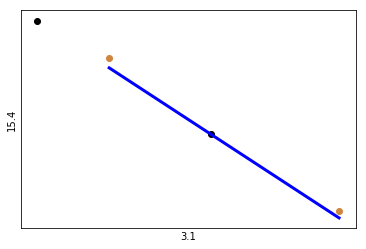

3.1 15.4
MAE: 0.43674
RMSE: 0.44217
R2: nan
Coefficient -0.8486111111111114
--------------------------




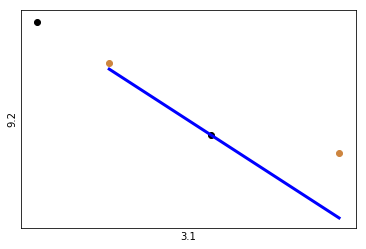

3.1 9.2
MAE: 0.26340
RMSE: 0.34164
R2: nan
Coefficient -0.11527777777777781
--------------------------


3.1 14.5
MAE: 3.09729
RMSE: 3.90597
R2: nan
Coefficient -1.2541666666666669
--------------------------




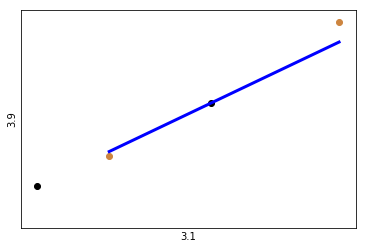

3.1 3.9
MAE: 0.00525
RMSE: 0.00617
R2: nan
Coefficient 0.005000000000000002
--------------------------


3.1 6.2
MAE: 1.52806
RMSE: 1.74118
R2: nan
Coefficient 0.9722222222222224
--------------------------




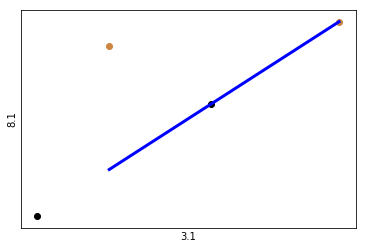

3.1 8.1
MAE: 0.49875
RMSE: 0.70357
R2: nan
Coefficient 0.12500000000000003
--------------------------




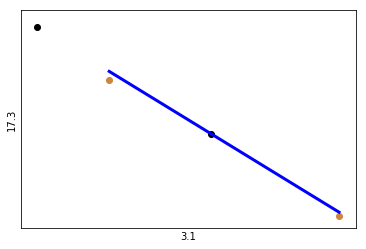

3.1 17.3
MAE: 0.01319
RMSE: 0.01416
R2: nan
Coefficient -0.030555555555555558
--------------------------


3.1 2.1
MAE: 1.44792
RMSE: 1.83232
R2: nan
Coefficient 0.5416666666666666
--------------------------


3.1 9.c
MAE: 21.96486
RMSE: 27.44581
R2: nan
Coefficient -4.436111111111112
--------------------------




In [27]:
keptPairs = list()
processedPairs = list()
notPercentTargets = ['12.2', '9.4', '8.4', '17.2', '17.19']   # work on this
highValueTargets = ['9.4', '17.19']
discardedPairs = list()
edgecolor = list()
pairsAndRel = {}

n_connections = 0

for targetx in targets:     #loop over all rows
        
        for targety in targets:    #loop over all rows except the one we're in now
            # avoid double processing of reverse pairs
            if not set([targetx, targety]) in processedPairs:
                processedPairs.extend([set([targetx, targety])])
                
                if not targety==targetx:
                    
                    if ((targety in notPercentTargets and not targetx in notPercentTargets) or targety in highValueTargets):
                        y = targetx
                        x = targety
                        targetx = x
                        targety = y


                    X = final_t_shuffled[targetx].reshape(-1,1)
                    Y = final_t_shuffled[targety].reshape(-1,1)

                    # apply mask to lists to filter out pairs containing any NaNs
                    mask = ~pd.isnull(X) & ~pd.isnull(Y)

                    X = X[mask]
                    Y = Y[mask]


                    # Split the data into training/testing sets
                    split = math.floor(2/3 * len(X))
                    X_train = X[:-split]
                    Y_train = Y[:-split]

                    X_valid = X[-split:]
                    Y_valid = Y[-split:]


                    if (len(X_train) > 1):

                        X_train = X_train.reshape(-1, 1)
                        Y_train = Y_train.reshape(-1, 1)
                        
                        X_valid = X_valid.reshape(-1, 1)
                        Y_valid = Y_valid.reshape(-1, 1)

                        linreg = linear_model.LinearRegression()
                        linreg.fit(X_train, Y_train)
                        
                        # Make predictions using the validation values
                        y_pred = linreg.predict(X_valid)
                        mae, rae, rmse, r2 = compute_error(Y_valid, y_pred)
                        
                        
                        coef = linreg.coef_[0][0]
                        
                        # filter out independant variables (coefficient close to 0, coefficient > 100)
                        if (0.001 < np.abs(coef) < 100):
                        
                            if targety in notPercentTargets:

                                if 0<=mae<0.1: # 1 percent tolerance (converted to tonnes)
                                    #print('MAE', targetx, targety, mae)
                                    keptPairs.extend([tuple((targetx, targety))])

                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])


                            else:
                                if 1 > mae > 0: # tolerate 1 percent error
                                    keptPairs.extend([tuple((targetx, targety))])
                                    
                                    if coef > 0: edge_color = 'g'#edgecolor.append('g')
                                    else: edge_color = 'r'
                                    
                                    edgecolor.append(edge_color)
                                    pairsAndRel[targetx, targety] = edge_color

                                    plt.scatter(X_train, Y_train,  color='black')
                                    plt.scatter(X_valid, Y_valid, color='peru')
                                    plt.plot(X_valid, y_pred, color='blue', linewidth=3)

                                    plt.xticks(())
                                    plt.yticks(())
                                    plt.xlabel(targetx)
                                    plt.ylabel(targety)
                                    plt.show()

                                    n_connections = n_connections + 1

                                else: discardedPairs.extend([[targetx, targety]])
                        
                        else: discardedPairs.extend([[targetx, targety]])

                        print(targetx, targety)
                        
                        print("MAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (mae, rmse, r2))
                        print('Coefficient', coef)
                        print('--------------------------')
                        print('\n')

#print(keptPairs)

In [28]:
print("Total number of connections found: ", n_connections)

Total number of connections found:  133


In [29]:
print(keptPairs)

[('12.2', '6.2'), ('12.2', '17.3'), ('12.2', '4.2'), ('12.2', '2.1'), ('12.2', '8.4'), ('3.3', '7.2'), ('3.3', '3.4'), ('3.3', '10.c'), ('3.3', '15.4'), ('3.3', '9.2'), ('3.3', '14.5'), ('3.3', '3.9'), ('12.2', '3.3'), ('16.a', '3.4'), ('16.a', '9.2'), ('16.a', '3.9'), ('7.2', '10.c'), ('7.2', '8.2'), ('7.2', '9.2'), ('12.2', '7.2'), ('3.4', '15.4'), ('3.4', '9.2'), ('3.4', '3.9'), ('15.1', '10.c'), ('15.1', '15.4'), ('15.1', '9.2'), ('15.1', '3.9'), ('12.2', '15.1'), ('10.c', '8.2'), ('10.c', '6.1'), ('10.c', '15.4'), ('10.c', '9.2'), ('8.2', '9.2'), ('8.2', '3.9'), ('17.8', '15.4'), ('17.8', '9.2'), ('17.8', '3.9'), ('6.1', '15.4'), ('6.1', '9.2'), ('6.1', '3.9'), ('12.2', '6.1'), ('15.4', '9.2'), ('15.4', '3.9'), ('12.2', '15.4'), ('9.2', '3.9'), ('12.2', '9.2'), ('14.5', '3.9'), ('6.2', '3.3'), ('6.2', '7.2'), ('6.2', '3.4'), ('6.2', '10.c'), ('6.2', '17.8'), ('6.2', '15.4'), ('6.2', '9.2'), ('6.2', '3.9'), ('6.2', '17.3'), ('6.2', '3.6'), ('6.2', '9.5'), ('6.2', '4.2'), ('6.2', '2

In [30]:
# seems like the high value targets are discarded more than the others, else, evenly distributed
print(discardedPairs)

[['12.2', '8.1'], ['12.2', '9.5'], ['12.2', '14.4'], ['9.4', '12.2'], ['17.19', '9.4'], ['17.19', '9.c'], ['17.19', '17.2'], ['3.3', '16.a'], ['3.3', '15.1'], ['3.3', '8.2'], ['3.3', '17.8'], ['3.3', '6.1'], ['17.19', '12.2'], ['16.a', '15.1'], ['16.a', '8.2'], ['16.a', '17.8'], ['16.a', '6.1'], ['16.a', '15.4'], ['16.a', '14.5'], ['12.2', '9.c'], ['12.2', '17.2'], ['7.2', '15.1'], ['7.2', '17.8'], ['7.2', '6.1'], ['7.2', '15.4'], ['3.4', '15.1'], ['3.4', '8.2'], ['3.4', '17.8'], ['3.4', '6.1'], ['3.4', '14.5'], ['15.1', '8.2'], ['15.1', '17.8'], ['15.1', '6.1'], ['15.1', '14.5'], ['10.c', '17.8'], ['8.2', '17.8'], ['8.2', '6.1'], ['8.2', '15.4'], ['8.2', '14.5'], ['12.2', '8.2'], ['17.8', '6.1'], ['17.8', '14.5'], ['12.2', '17.8'], ['6.1', '14.5'], ['15.4', '14.5'], ['9.2', '14.5'], ['6.2', '16.a'], ['6.2', '15.1'], ['6.2', '8.2'], ['6.2', '6.1'], ['6.2', '14.5'], ['6.2', '8.1'], ['6.2', '14.4'], ['9.4', '8.4'], ['9.4', '9.c'], ['9.4', '17.2'], ['8.1', '3.3'], ['8.1', '16.a'], ['8.1',

## 2. Graphical Models

In [31]:
import networkx as nx

In [32]:
G1 = nx.Graph()
G1.add_edges_from(keptPairs)

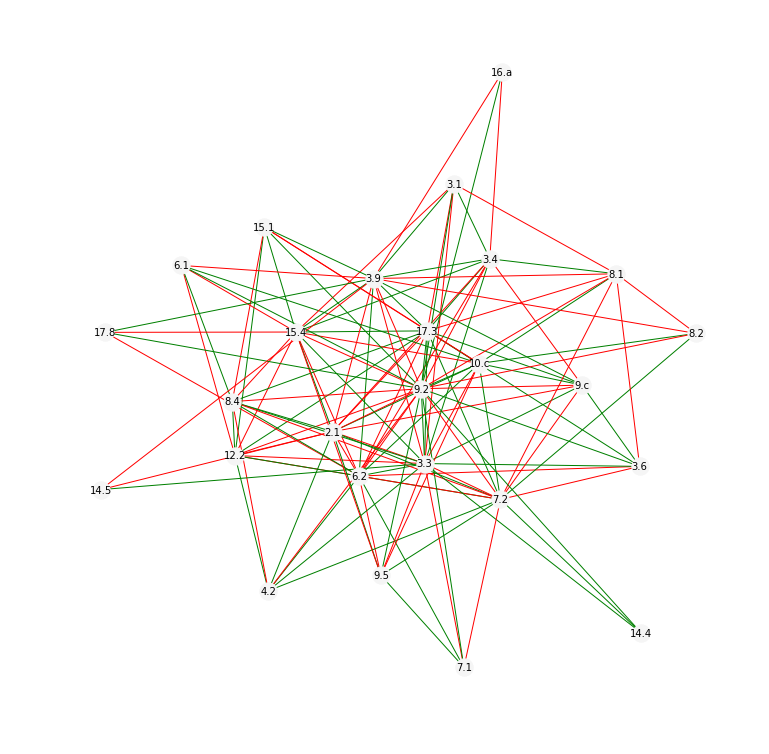

In [33]:
pos2 = nx.spring_layout(G1) # choose layout

plt.figure(1,figsize=(10,10)) 
nx.draw(G1,pos2, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.savefig("structure.png")
plt.show()

In this plot, the most connected and therefore most influential nodes are located in the middle of the graph.

In [34]:
from matplotlib.pyplot import imshow
%matplotlib inline
from PIL import Image

size = 1024,1024
circles = Image.open("Circle-Designs-01.png")
circles = circles.resize(size, Image.ANTIALIAS)
plot = Image.open("structure.png")
plot = plot.resize(size, Image.ANTIALIAS)
overlay = Image.blend(circles, plot,alpha=0.7)
overlay.show()
overlay.save("final.png")
#imshow(np.asarray(overlay), aspect='equal')

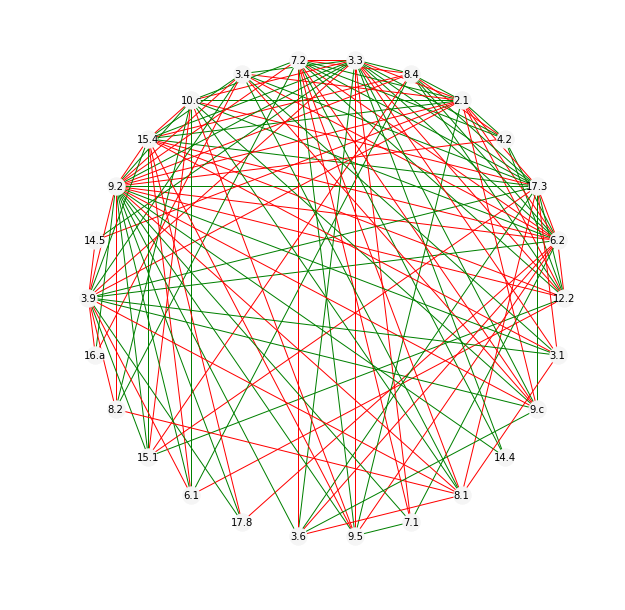

In [35]:
pos = nx.circular_layout(G1) # choose layout
# default

plt.figure(1,figsize=(8,8)) 
nx.draw(G1,pos, with_labels=True, edge_color=edgecolor, node_color='whitesmoke', font_size=10)
plt.show()

In [36]:
clique_list = list(nx.find_cliques(G1))
clique_list

[['14.5', '2.1', '3.9', '3.3'],
 ['9.2', '8.2', '8.1', '7.2', '10.c'],
 ['9.2', '8.2', '8.1', '3.9'],
 ['9.2', '17.8', '6.2', '3.9', '15.4'],
 ['9.2', '3.3', '14.4', '7.2'],
 ['9.2', '3.3', '6.2', '3.6', '7.2', '17.3'],
 ['9.2', '3.3', '6.2', '2.1', '4.2', '7.2', '12.2', '8.4'],
 ['9.2', '3.3', '6.2', '2.1', '9.5', '10.c', '7.2'],
 ['9.2', '3.3', '6.2', '2.1', '9.5', '10.c', '15.4'],
 ['9.2', '3.3', '6.2', '2.1', '17.3', '7.2', '12.2', '8.4'],
 ['9.2', '3.3', '6.2', '2.1', '17.3', '7.2', '10.c'],
 ['9.2', '3.3', '6.2', '2.1', '17.3', '15.4', '3.4', '3.9'],
 ['9.2', '3.3', '6.2', '2.1', '17.3', '15.4', '10.c'],
 ['9.2', '3.3', '6.2', '2.1', '17.3', '15.4', '8.4', '12.2'],
 ['9.2', '3.3', '6.2', '7.1', '9.5', '7.2'],
 ['9.2', '3.3', '9.c', '17.3', '3.6', '7.2'],
 ['9.2', '3.3', '9.c', '17.3', '2.1', '7.2', '10.c'],
 ['9.2', '3.3', '9.c', '17.3', '2.1', '3.4', '3.9'],
 ['9.2', '3.3', '3.1', '3.4', '3.9', '17.3', '15.4'],
 ['9.2', '16.a', '3.4', '3.9'],
 ['9.2', '15.1', '17.3', '15.4', '3.

In [37]:
# finding clique containing most nodes
length = 0
for c in clique_list:
    if len(c) > length:
        length = len(c)
        max_clique = c

In [38]:
import itertools

def complete_graph_from_list(L, create_using=None):
    G = nx.empty_graph()
    if len(L)>1:
        if G.is_directed():
            edges = itertools.permutations(L,2)
        else:
            edges = itertools.combinations(L,2)
        G.add_edges_from(edges)
    return G


In [39]:
cliqueGraph = complete_graph_from_list(max_clique)

In [40]:
cliqueGraph_edges = list(cliqueGraph.edges)
pairsDictListKeys = list(pairsAndRel.keys())

In [41]:
clique_e_color = []
for edge in cliqueGraph_edges:
    if edge in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge])
    elif edge[::-1] in pairsDictListKeys:
        clique_e_color.append(pairsAndRel[edge[::-1]])

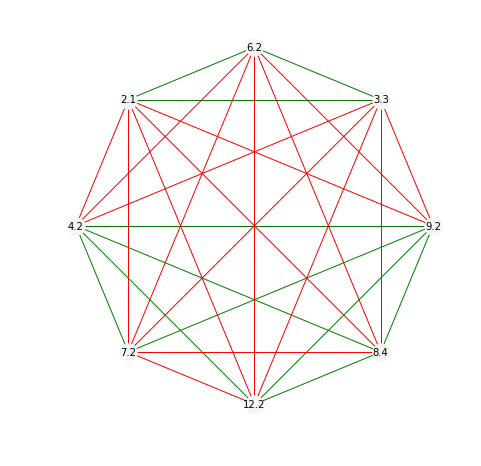

In [42]:
#cliqueGraph.add_nodes_from(max_clique)
pos9 = nx.shell_layout(cliqueGraph)
plt.figure(1,figsize=(6,6)) 
nx.draw(cliqueGraph,pos9, with_labels=True, font_size=10, edge_color=clique_e_color, node_color='whitesmoke')
plt.show()

## 2. Build temporal model to infer missing observations

We have a temporal model with missing observations as NaNs, and want to infer them

In [43]:
# convert data to a matrix
y = df.as_matrix()
y = y[:(6*24*1)]
N, D = y.shape
print("N=%d, D=%d" % (N,D))

N=144, D=43


# What is observed and what is missing?

#perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)] # missing indexes
ix_obs1 = perm1[int(missing_perc * N):] # observed indexes
y_mis1 = y[ix_mis1,7]
y_obs1 = y[ix_obs1,7]

#perm2 = np.random.permutation(N)
ix_mis2 = perm2[:int(missing_perc * N)] # missing indexes
ix_obs2 = perm2[int(missing_perc * N):] # observed indexes
y_mis2 = y[ix_mis2,8]
y_obs2 = y[ix_obs2,8]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
print("N_obs:", N_obs)
print("N_mis:", N_mis)

## Define STAN model

From now on, we can actually forget all information we've gotten so far. With the implementation in STAN, we will gain insights for the following two questions in one single model (wow - so amazing :-) ):

**1. How are Targets correlated?**

**2. What are expectable values for missing observations (imputing)?**

Note that we observe two time-series simultaneously. We will model the correlations between the two time-series in the latent state $\textbf{z}_t$. We will assume that our latent state is 2-dimensional $\textbf{z}_t = \{z_{t,1},z_{t,2}\}$ with latent dynamics:
\begin{align}
\textbf{z}_t &\sim \mathcal{N}(\boldsymbol\beta \textbf{z}_{t-1}, \boldsymbol\Sigma)
\end{align}
And likelihoods:
\begin{align}
y_{t,1} &\sim \mathcal{N}(z_{t,1}, \sigma^2)\\
y_{t,2} &\sim \mathcal{N}(z_{t,2}, \sigma^2)
\end{align}
Or (equivalent):
\begin{align}
\textbf{y}_t &\sim \mathcal{N}(\textbf{z}_t, \sigma^2 \textbf{I})
\end{align}

The key element in the model described above is the **covariance matrix $\boldsymbol\Sigma$** which embodies the object that will allow us to capture the correlations between the two time-series.

In STAN, the recommended approach is to decompose the covariance matrix $\boldsymbol\Sigma$ into a *scale* and a *matrix*, but we are able to do so in a more natural way based on the actual variable scales and a correlation matrix. Specifically, we define:

\begin{align}
\boldsymbol\Sigma = \mbox{diag_matrix}(\boldsymbol\tau) \, \boldsymbol\Omega \, \mbox{diag_matrix}(\boldsymbol\tau)
\end{align}

where $\mbox{diag_matrix}(\boldsymbol\tau)$ denotes a diagonal matrix with diagonal elements given by the vector $\boldsymbol\tau$. In this parameterization, $\boldsymbol\Omega$ can be regarded as a correlation matrix and $\boldsymbol\tau$ is a vector of coefficient scales.

Similar to any other variable, we also must assign priors to $\boldsymbol\tau$ and $\boldsymbol\Omega$. The components of the scale vector $\boldsymbol\tau$ can be given any reasonable prior for scales, but something weakly informative like a half-Cauchy distribution with a small scale is recommended, such as:

\begin{align}
\boldsymbol\tau ∼ Cauchy(0, 1.0) , \, \mbox{with the constraint:} \, \boldsymbol\tau > 0
\end{align}

As for the correlation matrix $\boldsymbol\Omega$, the STAN manual recommends a LKJ prior like:

\begin{align}
\boldsymbol\Omega ∼ LKJCorr(10.0)
\end{align}

Finally, we can define a multivariate Gaussian with parameters $\boldsymbol\mu$, $\boldsymbol\tau$ and $\boldsymbol\Omega$ using:

multi_normal(mu, quad_form_diag(Omega, tau))


To impute missing observations, we do

\begin{align}
y_{t} &\sim \mathcal{N} \Big(\beta_{1} y_{t-1} + \beta_{2} y_{t-2} + ... + \beta_{T} y_{t-T} \Big)
\end{align}

Note that we want to make the missing observation dependent on one previous observation. This is equivalent to define an autoregressive model of order 1.

In [44]:
SDG_STAN="""
data {
    int<lower = 0> N_obs1;
    int<lower = 0> N_mis1;    // how many do we want to infer
    int<lower = 0> N_obs2;  
    int<lower = 0> N_mis2;
    int<lower = 1, upper = N_obs1 + N_mis1> ix_obs1[N_obs1];    // index for observed time steps of target 1
    int<lower = 1, upper = N_obs1 + N_mis1> ix_mis1[N_mis1];
    int<lower = 1, upper = N_obs2 + N_mis2> ix_obs2[N_obs2];    // index for observed time steps of target 2
    int<lower = 1, upper = N_obs2 + N_mis2> ix_mis2[N_mis2];
    real y_obs1[N_obs1];         // observed time-series data for target 1
    real y_obs2[N_obs2];         // observed time-series data for target 2
}

transformed data {
    int<lower = 0> T = N_obs1 + N_mis1;  // length of the time-series
}

parameters {
    vector[1] beta[2];            // state transition coefficients. 
    corr_matrix[2] Omega;       // gives us the correlation with **Omega[1,2]=Omega[2,1]=Cov(1,2)**; Omega[1,1]=Var(1);Omega[2,2]=Var(2)    1 is target 1, 2 is target 2
    vector<lower=0>[2] tau;
    real<lower=0> sigma;       // observation noise
    matrix[T,2] z;             // vector of latent states
    real y_mis1[N_mis1];        // missing time-series data to infer for target 1
    real y_mis2[N_mis2];        // missing time-series data to infer for target 2
}

transformed parameters {
    real y1[T];
    real y2[T];
    matrix[2,2] L_sigma;
    y1[ix_obs1] = y_obs1;
    y1[ix_mis1] = y_mis1;
    y2[ix_obs2] = y_obs2;
    y2[ix_mis2] = y_mis2;
}

model {
    for(i in 1:2)                   
        beta[i] ~ normal(0,1);            // prior on the auto-regressive coefficients
    tau ~ cauchy(0,1);
    Omega ~ lkj_corr(10.0);         // STAN manual Section 63.1 (recommendation is lkj_corr)
    sigma ~ cauchy(0,1);            // prior on the variance
    
    z[1,:] ~ normal(0,1);           // prior on first state
    
    for(t in 2:T) {
        vector[2] mu;                          // mu is a vector of the means of our multivariate normal 
        mu[1] = beta[1]' * z[(t-1):(t-1),1];   // mu[1] is the mean of target 1 
        mu[2] = beta[2]' * z[(t-1):(t-1),2];   // mu[2] is the mean of target 2
        z[t,:] ~ multi_normal(mu, quad_form_diag(Omega, tau)); // latent dynamics
    }
    
    y1 ~ normal(z[:,1], sigma);    // likelihood for target 1
    y2 ~ normal(z[:,2], sigma);    // likelihood for target 2
}
"""

# what to do next: define huge for loop over all what follows from here?

In [45]:
clique_nodes = list(cliqueGraph.nodes)
clique_nodes

['9.2', '3.3', '6.2', '2.1', '4.2', '7.2', '12.2', '8.4']

In [46]:
clique_df_t = final_t[clique_nodes]
clique_df_t

Target,9.2,3.3,6.2,2.1,4.2,7.2,12.2,8.4
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991,NaN,NaN,NaN,18.6,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,18.5,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,18.2,NaN,NaN,NaN,NaN


In [47]:
clique_df_t = clique_df_t[clique_df_t.index > '1990']
clique_df_t

Target,9.2,3.3,6.2,2.1,4.2,7.2,12.2,8.4
1991,NaN,NaN,NaN,18.6,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,18.5,NaN,NaN,NaN,NaN
1993,NaN,NaN,NaN,18.2,NaN,NaN,NaN,NaN
1994,NaN,NaN,NaN,17.8,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,17.2,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,16.6,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,16.1,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,15.7,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,15.3,NaN,NaN,NaN,NaN
2000,15.15,17.2,33.76,15,NaN,17.45,8,8


- N_obs: Number of observed values (length of loc array)
- N_mis: Number of missing values (length of loc array)
- ix_obs: indices of observed values
- ix_mis: indices of missing values
- y_obs: observed values

In [48]:
# prepare data for STAN model
def prepareInputData(df, target1, target2):
    t1_list = df[target1].tolist()
    t2_list = df[target2].tolist()
    
    ix_obs1 = np.where(~np.isnan(t1_list))[0]
    ix_obs2 = np.where(~np.isnan(t2_list))[0]
    
    ix_mis1 = np.where(np.isnan(t1_list))[0]
    ix_mis2 = np.where(np.isnan(t2_list))[0]
    
    y_obs1 = [t1_list[index] for index in ix_obs1]
    y_obs2 = [t2_list[index] for index in ix_obs2]
    
    N_obs1 = len(ix_obs1)
    N_obs2 = len(ix_obs2)
    
    N_mis1 = len(ix_mis1)
    N_mis2 = len(ix_mis2)
    
    data = {'N_obs1': N_obs1, 'N_mis1': N_mis1, 'N_obs2': N_obs2, 'N_mis2': N_mis2,
            'ix_obs1': ix_obs1+1, 'ix_mis1': ix_mis1+1, 'y_obs1': y_obs1, 
            'ix_obs2': ix_obs2+1, 'ix_mis2': ix_mis2+1, 'y_obs2': y_obs2}
    
    return data

In [49]:
%%time
# create STAN model object (compile STAN model)
sm = pystan.StanModel(model_code=SDG_STAN)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2735134c49bf882717185f3ab58537a3 NOW.


CPU times: user 1.23 s, sys: 98.3 ms, total: 1.33 s
Wall time: 1min 4s


In [50]:
'''

# run inference using MCMC sampling
fit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
print(fit)

samples = fit.extract(permuted=True)  # return a dictionary of arrays

# what do we actually want to show? sigma and tau are performance measurements. Interesting for us, but we want to see more
fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
plt.show()'''

'\n\n# run inference using MCMC sampling\nfit = sm.sampling(data=data, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)\nprint(fit)\n\nsamples = fit.extract(permuted=True)  # return a dictionary of arrays\n\n# what do we actually want to show? sigma and tau are performance measurements. Interesting for us, but we want to see more\nfit.plot(["tau","sigma","lp__"]) # take vars from temporal model\nplt.show()'

#### Compute mean and standard devitions for the imputed values of the time-series and visualize them (in comparison with the corresponding true values):

In [51]:
'''# get mean and standard devitions for predictions
y_hat1 = samples["y_mis1"].mean(axis=0)
y_std1 = samples["y_mis1"].std(axis=0)

y_hat2 = samples["y_mis2"].mean(axis=0)
y_std2 = samples["y_mis2"].std(axis=0)
'''

'# get mean and standard devitions for predictions\ny_hat1 = samples["y_mis1"].mean(axis=0)\ny_std1 = samples["y_mis1"].std(axis=0)\n\ny_hat2 = samples["y_mis2"].mean(axis=0)\ny_std2 = samples["y_mis2"].std(axis=0)\n'

In [52]:
'''
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast","forecast + stddev","forecast - stddev"])
'''

'\nplt.plot(ix_obs1, y_obs1, "bo")\nplt.plot(ix_mis1, y_mis1, "bx")\nplt.plot(ix_mis1, y_hat, "rx")\n#plt.plot(ix_mis, y_hat + y_std, "r--")\n#plt.plot(ix_mis, y_hat - y_std, "r--")\nplt.legend(["true","forecast","forecast + stddev","forecast - stddev"])\n'

Compute error statistics of the model's imputations:

In [53]:
def compute_error2(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [54]:
'''
# insert def compute_error if deleted above
corr, mae, rae, rmse, r2 = compute_error2(y_mis1, y_hat) #for missing variables
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))
'''

'\n# insert def compute_error if deleted above\ncorr, mae, rae, rmse, r2 = compute_error2(y_mis1, y_hat) #for missing variables\nprint("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))\n'

### What our for-loop will look like (-ish)

#### Questions
- Which targets do we want to pair and use for pairwise inference?
    - first find out which is the one giving the least error and continue from there?
    - all possible pairs?
- How about the timesteps?
- Use all times or first from 1990  (no data before 1990 for any of the targets we want to analyze

In [55]:
from scipy.stats import pearsonr

t1_list = clique_df_t['3.3'].tolist()
t2_list = clique_df_t['17.3'].tolist()

mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
print(mask)
t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
t2_list = list(itertools.compress(t2_list, mask))

print(t1_list)
print(t2_list)
#correlation between two targets
corrCoef = pearsonr(t1_list, t2_list)
print(corrCoef)

In [57]:
def calcCorr(target1, target2):
    # list of values
    t1_list = clique_df_t[target1].tolist()
    t2_list = clique_df_t[target2].tolist()
                    
    #correlation between two targets
    mask = ~pd.isnull(t1_list) & ~pd.isnull(t2_list)
    t1_list = list(itertools.compress(t1_list, mask))#t1_list[mask]
    t2_list = list(itertools.compress(t2_list, mask))

                    
    #correlation between two targets
    corrCoef = pearsonr(t1_list, t2_list)[0]
    
    return corrCoef

To find out which pairs would give the most cartain results after inference, we want to find the pairs that have the highest correlation between each other (lowest uncertainty in prediction). This is why we first calculate the correlation coefficient and choose the pairs that give the highest correlation coefficients.

In [58]:
# find pairs with best correlation coefficient
bestCorrPairs = []
processedPairs = []
corrCoefs = []

for targetx in clique_nodes:     #loop over all rows
    
    bestCorrCoef = 0
    
    for targety in clique_nodes:    #loop over all rows except the one we're in now
        # avoid double processing of reverse pairs
        if not set([targetx, targety]) in processedPairs:
            processedPairs.extend([set([targetx, targety])])
                
            if not targety==targetx:
                corr = calcCorr(targetx, targety)
                if (np.abs(corr) > np.abs(bestCorrCoef) and not (corr==0 or corr==1)):
                    bestCorrCoef = corr
                    bestPair = tuple([targetx, targety])
        
        else: continue           
    
    bestCorrPairs.append(bestPair)
    corrCoefs.append(bestCorrCoef)
    
for i in range(0,len(bestCorrPairs)):
    print(bestCorrPairs[i], ': ', corrCoefs[i])


('9.2', '6.2') :  -0.8563738992028099
('3.3', '2.1') :  0.9877502596564228
('6.2', '2.1') :  0.9759405924633682
('2.1', '4.2') :  -0.929970408807261
('4.2', '12.2') :  0.9569108344220997
('7.2', '12.2') :  -0.011608155542496184
('7.2', '12.2') :  0
('7.2', '12.2') :  0


In [60]:
list(set(bestCorrPairs))

[('6.2', '2.1'),
 ('4.2', '12.2'),
 ('9.2', '6.2'),
 ('3.3', '2.1'),
 ('7.2', '12.2'),
 ('2.1', '4.2')]

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      1.03  1.0e-3   0.01    1.0   1.02   1.03   1.04   1.05    186   1.01
beta[1,0]      1.01  7.1e-4   0.02   0.97    1.0   1.01   1.02   1.05    714    1.0
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.58  8.5e-3   0.15   0.24   0.49    0.6    0.7   0.83    318   1.01
Omega[0,1]     0.58  8.5e-3   0.15   0.24   0.49    0.6    0.7   0.83    318   1.01
Omega[1,1]      1.0 1.1e-177.9e-17    1.0    1.0    1.0    1.0    1.0     53    nan
tau[0]         0.99    0.01   0.17   0.71   0.85   0.96    1.1    1.4    238   1.01
tau[1]         2.49    0.03   0.45   1.83   2.17   2.42   2.76   3.54    274   1.01
sigma          0.16    0.04   0.09   0.01    0.1   0.15   

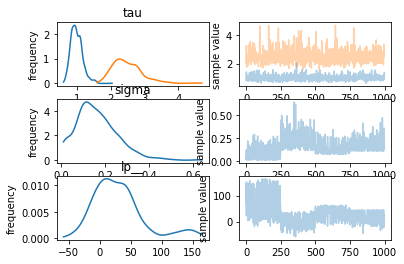

/Users/GalinaJonat/anaconda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      1.01  1.9e-3   0.04   0.93   0.98   1.01   1.03   1.08    377   1.01
beta[1,0]      0.98  2.1e-3   0.05   0.86   0.94   0.98   1.02   1.08    626    1.0
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.14    0.01    0.2  -0.25-2.0e-3   0.15   0.28   0.52    380   1.01
Omega[0,1]     0.14    0.01    0.2  -0.25-2.0e-3   0.15   0.28   0.52    380   1.01
Omega[1,1]      1.0 3.3e-189.9e-17    1.0    1.0    1.0    1.0    1.0    912    nan
tau[0]         2.38    0.06   0.67   1.39   1.89   2.26   2.77    4.0    109   1.06
tau[1]          3.3    0.04   0.83   1.95   2.71   3.19   3.74   5.23    362    1.0
sigma           3.7    0.07   0.65   2.72   3.25   3.63   

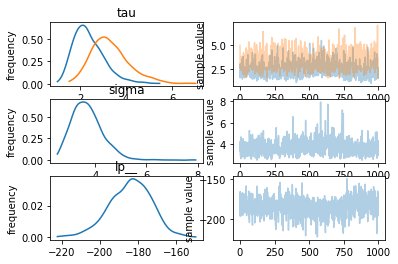

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]       1.0 10.0e-4   0.03   0.94   0.98    1.0   1.02   1.07   1000    1.0
beta[1,0]      0.98  1.8e-3   0.06   0.85   0.95   0.98   1.01   1.07   1000    1.0
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.15  8.1e-3    0.2  -0.24   0.01   0.16   0.28   0.52    585   1.01
Omega[0,1]     0.15  8.1e-3    0.2  -0.24   0.01   0.16   0.28   0.52    585   1.01
Omega[1,1]      1.0 3.0e-189.5e-17    1.0    1.0    1.0    1.0    1.0   1000    nan
tau[0]         4.01    0.05   0.93   2.56   3.39   3.88   4.48    6.2    396    1.0
tau[1]         3.47    0.06   0.95   2.05    2.8   3.32   3.97   5.85    277   1.02
sigma          3.93    0.03   0.63   2.89   3.48   3.85   

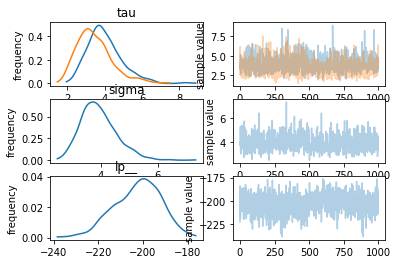

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      0.87    0.11   0.32  -0.23   0.93   0.97   1.01   1.07      8   1.78
beta[1,0]      0.89    0.16   0.41  -0.63   1.01   1.03   1.05   1.09      7   1.82
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.15    0.06   0.22  -0.25-5.6e-3   0.16    0.3   0.54     13   1.09
Omega[0,1]     0.15    0.06   0.22  -0.25-5.6e-3   0.16    0.3   0.54     13   1.09
Omega[1,1]      1.0 3.1e-189.5e-17    1.0    1.0    1.0    1.0    1.0    936    nan
tau[0]         2.94    0.31   1.19   0.22   2.39   3.04   3.66   5.19     15   1.47
tau[1]         4.99    0.58   2.33   0.15   4.08   5.02   6.13   9.92     16   1.49
sigma          8.64    4.54  11.13   3.19    3.8   4.29   

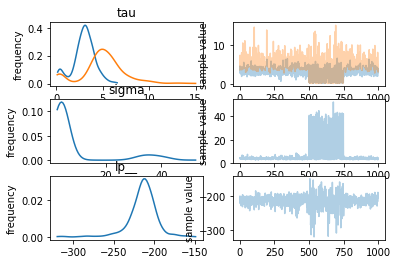

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      0.74    0.34   0.59  -0.85   0.98   1.03   1.04   1.07      3    2.6
beta[1,0]      0.76    0.38   0.54  -0.72   0.98   1.03   1.05   1.08      2   2.46
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.21    0.09   0.23  -0.31   0.07   0.24   0.38    0.6      6   1.22
Omega[0,1]     0.21    0.09   0.23  -0.31   0.07   0.24   0.38    0.6      6   1.22
Omega[1,1]      1.0 3.3e-189.1e-17    1.0    1.0    1.0    1.0    1.0    778    nan
tau[0]         3.18    1.24   1.76   0.12    1.9   3.58   4.28   6.06      2   2.35
tau[1]         1.57    1.21   2.42   0.29    0.5   0.66   0.97    9.9      4   1.54
sigma         11.31   13.83  19.55   0.09   0.13    0.2  1

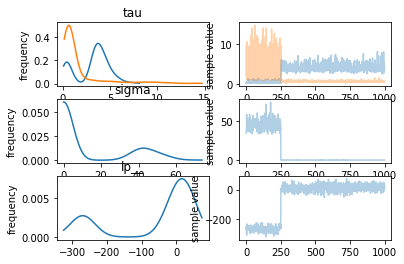

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      1.03  6.1e-4   0.02   0.99   1.01   1.03   1.04   1.07   1000    1.0
beta[1,0]      1.04  9.9e-4   0.02   1.01   1.03   1.04   1.05   1.08    317   1.01
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[0,1]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[1,1]      1.0 3.1e-188.7e-17    1.0    1.0    1.0    1.0    1.0    786    nan
tau[0]         1.33    0.02   0.28   0.93   1.13   1.29   1.47   1.96    243   1.01
tau[1]         0.55    0.01   0.17    0.3   0.43   0.53   0.64   0.97    182   1.02
sigma          0.11    0.02   0.06   0.03   0.06   0.09   

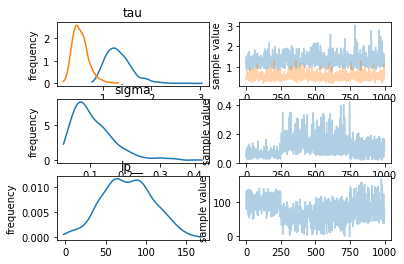

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      1.03  6.1e-4   0.02   0.99   1.01   1.03   1.04   1.07   1000    1.0
beta[1,0]      1.04  9.9e-4   0.02   1.01   1.03   1.04   1.05   1.08    317   1.01
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[0,1]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[1,1]      1.0 3.1e-188.7e-17    1.0    1.0    1.0    1.0    1.0    786    nan
tau[0]         1.33    0.02   0.28   0.93   1.13   1.29   1.47   1.96    243   1.01
tau[1]         0.55    0.01   0.17    0.3   0.43   0.53   0.64   0.97    182   1.02
sigma          0.11    0.02   0.06   0.03   0.06   0.09   

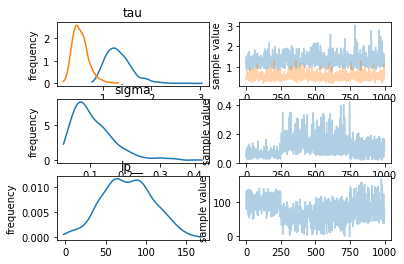

Inference for Stan model: anon_model_2735134c49bf882717185f3ab58537a3.
4 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0,0]      1.03  6.1e-4   0.02   0.99   1.01   1.03   1.04   1.07   1000    1.0
beta[1,0]      1.04  9.9e-4   0.02   1.01   1.03   1.04   1.05   1.08    317   1.01
Omega[0,0]      1.0     0.0    0.0    1.0    1.0    1.0    1.0    1.0   1000    nan
Omega[1,0]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[0,1]     0.36  8.1e-3   0.17-2.1e-3   0.25   0.37   0.49   0.67    462    1.0
Omega[1,1]      1.0 3.1e-188.7e-17    1.0    1.0    1.0    1.0    1.0    786    nan
tau[0]         1.33    0.02   0.28   0.93   1.13   1.29   1.47   1.96    243   1.01
tau[1]         0.55    0.01   0.17    0.3   0.43   0.53   0.64   0.97    182   1.02
sigma          0.11    0.02   0.06   0.03   0.06   0.09   

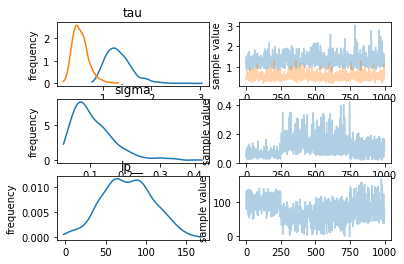

In [59]:
for pair in list(set(bestCorrPairs)):
    targetx = pair[0]
    targety = pair[1]

    # prepare input data
    inData = prepareInputData(clique_df_t, targetx, targety)

    # run inference using MCMC sampling
    fit = sm.sampling(data=inData, iter=500, chains=4, algorithm="NUTS", seed=42, verbose=True)
    print(fit)
    
    # what do we actually want to show? sigma and tau are performance measurements. Interesting for us, but we want to see more
    fit.plot(["tau","sigma","lp__"]) # take vars from temporal model
    plt.show()

    samples = fit.extract(permuted=True)

In [78]:
y_mis1 = samples['y_mis1']
y_mis2 = samples['y_mis2']
ix_mis1 = inData['ix_mis1']
ix_mis2 = inData['ix_mis2']
ix_obs1 = inData['ix_obs1']
ix_obs2 = inData['ix_obs2']
y_obs1 = inData['y_obs1']
y_obs2 = inData['y_obs2']

In [81]:
y_mis1[0]

array([-0.92573754,  0.89111705,  3.10870594,  6.55200651,  7.91888238,
        8.80569038, 10.17876164, 11.45895607, 15.55206636, 15.49035221,
       15.89561204, 16.95057043])

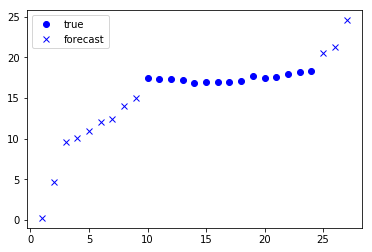

In [83]:
# final step (-ish): get out y1 and y2 and plot them
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1[1], "bx")
#plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast"])#,"forecast + stddev","forecast - stddev"])

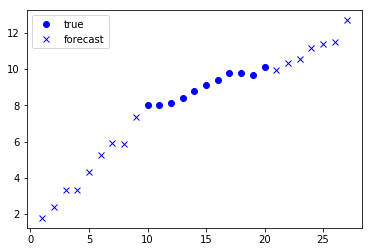

In [84]:
plt.plot(ix_obs2, y_obs2, "bo")
plt.plot(ix_mis2, y_mis2[0], "bx")
#plt.plot(ix_mis1, y_hat, "rx")
#plt.plot(ix_mis, y_hat + y_std, "r--")
#plt.plot(ix_mis, y_hat - y_std, "r--")
plt.legend(["true","forecast"])

Question: which of the y_mis to choose??